In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import os
from sklearn import preprocessing
import seaborn as sns
from scipy.stats import pearsonr
import xarray
from matplotlib.dates import DateFormatter

# functions

In [3]:
def get_path_holfuy(station, year, format=None):
    if year == 2022 and format=='csv_2021':
        folder = 'C:\\Users\\Aaron\\Documents\\pubblications\\paper1_anomalies\\data\\holfuy\\2022\\holfuy_manual_readings_2022\\'
        filename = str(station)+'_manual.csv'
        path = os.path.join(folder, filename)
        return path
    elif year == 2021 and format=='csv_2021':
        folder = 'C:\\Users\\Aaron\\Documents\\pubblications\\paper1_anomalies\\data\\holfuy\\2021\\final_readings_ablation\\'
        filename = str(station)+'_abl_sum.csv'
        path = os.path.join(folder, filename)
        return path
    elif year == 2019 and format=='csv_2021':
        folder = 'C:\\Users\\Aaron\\Documents\\pubblications\\paper1_anomalies\\data\\holfuy\\2019\\'
        filename = str(station)+'_abl_sum_final.csv'
        path = os.path.join(folder, filename)
        return path
    elif year == 2020 and format=='csv_2021':
        folder = 'C:\\Users\\Aaron\\Documents\\pubblications\\paper1_anomalies\\data\\holfuy\\2020\\'
        filename = str(station)+'_abl_sum_final.csv'
        path = os.path.join(folder, filename)
        return path

    elif format=='standard_point':
        folder = 'C:\\Users\\Aaron\\Documents\\pubblications\\paper1_anomalies\\data\\holfuy\\2020\\holfuy_manual_readings_2020\\'
        if station==1001 or station==1008:
            filename = 'findelen_intermediate.dat'
        elif station==1002 or station==1006 or station==1007:
            filename = 'rhone_intermediate.dat'
        elif station==1003:
            filename = 'plainemorte_intermediate.dat'
            
        path = os.path.join(folder, filename)
        return path


def get_path_clim(station):
    if station == 1008:
        path = 'C:\\Users\\Aaron\\Documents\\pubblications\\paper1_anomalies\\data\\climatology\\point_mb_Aaron\\cumulative_fin_200.dat'
    elif station == 1001:
        path = 'C:\\Users\\Aaron\\Documents\\pubblications\\paper1_anomalies\\data\\climatology\\point_mb_Aaron\\cumulative_fin_700.dat'
    elif station == 1003:
        path = 'C:\\Users\\Aaron\\Documents\\pubblications\\paper1_anomalies\\data\\climatology\\point_mb_Aaron\\cumulative_plm_P6.dat'
    elif station == 1007:
        path = 'C:\\Users\\Aaron\\Documents\\pubblications\\paper1_anomalies\\data\\climatology\\point_mb_Aaron\\cumulative_rho_P5.dat'
    elif station == 1002:
        path = 'C:\\Users\\Aaron\\Documents\\pubblications\\paper1_anomalies\\data\\climatology\\point_mb_Aaron\\cumulative_rho_P6.dat'
    elif station == 1006:
        path = 'C:\\Users\\Aaron\\Documents\\pubblications\\paper1_anomalies\\data\\climatology\\point_mb_Aaron\\cumulative_rho_P8.dat'
    return path


def import_climatology(path):
    head = pd.read_csv(
        path, sep=';', skiprows=2, skipinitialspace=True,
        header=0, nrows=0, encoding='latin1').columns

    usecols = np.arange(len(head))
    colnames = head
    climatology = pd.read_csv(path,
                           skiprows=4, sep=' ', skipinitialspace=True,
                           usecols=usecols, header=None,
                           names=colnames, dtype={'date_s': str,
                                                  'date_f': str,
                                                  'date0': str,
                                                  'date1': str})
    climatology.columns = climatology.columns.str.rstrip()
    climatology.columns = climatology.columns.str.replace('# ', '')
    climatology = climatology.drop_duplicates()
    try:
        climatology = climatology[climatology['Hyd.year']>= 2010]
    except:
        climatology = climatology[climatology['Hyd.year ']>= 2010]
    #print(climatology)
    return climatology


def import_holfuy(fpath=None, station=None, year=None, ice_only=False, exclude_keywords=True, format=None):
    """

    Parameters
    ----------
    fpath
    ice_only
    exclude_keywords
    format: standard: original format from johannes

    Returns
    -------

    """
    if not fpath:
        fpath = get_path_holfuy(station, year, format)
    if format=='standard_csv':
        cread = pd.read_csv(fpath, index_col=None, parse_dates=[0])

        # exclude some of the critical days
        if exclude_keywords:
            cread = cread[~cread.key_remarks.str.contains("SETUP", na=False)]
            # cread = cread[~cread.key_remarks.str.contains("REDRILL", na=False)]
            cread = cread[~cread.key_remarks.str.contains("TEARDOWN", na=False)]

        if ice_only:
            cread = cread[cread.phase == 'i']  # exclude snow

        return cread

    elif format=='standard_point':
        head = pd.read_csv(
            fpath, sep=';', skiprows=1, skipinitialspace=True,
            header=0, nrows=0, encoding='latin1').columns
        usecols = np.arange(len(head))
        colnames = head
        df = pd.read_csv(fpath,
                         skiprows=4, sep=' ', skipinitialspace=True,
                         usecols=usecols, header=None,
                         names=colnames, dtype={'date0': str,
                                                'date1': str})
        df.columns = df.columns.str.rstrip()
        df.columns = df.columns.str.replace('# ', '')
        df = df.drop_duplicates()
        # manual remove error in the glazioarch files
        try:
            if df.loc[269]['name']=='HF1008':
                df = df.drop(index=269)
        except:
            pass

        if not station:
            df = df[df['name'].str.contains('|'.join('HF'))]
        else:
            df = df[df['name'].str.contains('HF'+str(station))]
        
        #print(df)
        selection = df[['date0', 'date1', 'mb_we']]

        date0 = [dt.datetime(int(x[0:4]), int(x[4:6]), int(x[6:])) for x in selection['date0'].values]
        date1 = [dt.datetime(int(x[0:4]), int(x[4:6]), int(x[6:])) for x in selection['date1'].values]
        selection = selection.assign(date0=date0)
        selection = selection.assign(date1=date1)
        selection = selection[['date0', 'date1', 'mb_we']]
        if year is not None:
            selection = selection[selection['date0'].dt.year == year]
        return selection

    elif format=='csv_2021':
        cread = pd.read_csv(fpath, index_col=None, parse_dates=[0], dayfirst=True)
        return cread
    elif format=='winter':
        cread = pd.read_excel(fpath, index_col=None)#, parse_dates=[0], dayfirst=True)
        return cread
    elif format=='mh_2021':
        #path_mh = 'C:\\Users\\Aaron\\Documents\\pubblications\\paper1_anomalies\\data\\holfuy\\2021\\holfuy_manual_readings_2021\\matthias\\fin1001_p700_holfuy2021.xlsx'
        holfuy_mh = pd.read_excel(fpath, index_col=None, skiprows=8, usecols=[0, 6], names=['date', 'mb[m.w.e]'])
        holfuy_mh = holfuy_mh.loc[holfuy_mh['date'].notnull()]
        holfuy_mh['mb[m.w.e]'] = holfuy_mh['mb[m.w.e]']/100
        return holfuy_mh
    else:
        return None
    
    
def interpolate_holfuy_df(df, mode=None):
    if mode is not None:
        time = np.arange(df['date'].values[0], df['date'].values[-1])
    else:
        time = np.arange(df['date'].values[0], df['date'].values[-1], dt.timedelta(days=1))
    not_yet_interpolated_holfuy = []
    for t in time:
        if t in df['date'].values:
            not_yet_interpolated_holfuy.append(df[df['date'] == t]['mb[m.w.e]'].values[0])
        else:
            not_yet_interpolated_holfuy.append(np.nan)

    interpolated_df = pd.DataFrame({'date': time, 'mb[m.w.e]': not_yet_interpolated_holfuy})
    if interpolated_df['mb[m.w.e]'].isnull().values.any():
        interpolated_df['mb[m.w.e]'] = interpolated_df['mb[m.w.e]'].interpolate(axis=0)
    return interpolated_df    


def get_mb_beg_year_to_holfuy_period(df, station, year):
    if year == 2021:
        return 0
    else:
        path = 'C:\\Users\\Aaron\\Documents\\pubblications\\paper1_anomalies\\data\\holfuy\\mb_begin_holfuy_period.xlsx'
        mb_begin_df = pd.read_excel(path)
        indexes = mb_begin_df[(mb_begin_df['station']!=station) | (mb_begin_df['date'].dt.year!=year)].index
        # droping mutiple rows based on column value
        mb_begin_df = mb_begin_df.drop(indexes)
        date = mb_begin_df['date'].values[0]
        mb = mb_begin_df['mb[m.w.e]'].values[0]
        #print(date, mb)
        shift = mb - df[df['date']==date]['mb[m.w.e]'].values[0]
        return shift

    
def get_date_last_meas(station, year):
    path = 'C:\\Users\\Aaron\\Documents\\pubblications\\paper1_anomalies\\data\\holfuy\\mb_begin_holfuy_period.xlsx'
    mb_begin_df = pd.read_excel(path)
    indexes = mb_begin_df[(mb_begin_df['station']!=station) | (mb_begin_df['date'].dt.year!=year)].index
    # droping mutiple rows based on column value
    mb_begin_df = mb_begin_df.drop(indexes)
    date = mb_begin_df['date_meas'].values[0]
    return date


def get_mb_last_meas_to_end(station, date):
    clim = import_climatology(get_path_clim(station))
    date = date.astype('datetime64[s]')
    date = date.astype(dt.datetime)
    clim = clim[clim['Hyd.year'] == date.year]
    mb_3009 = clim['balance(b)'].values[-1]
    clim = clim[clim['Month'] == date.month]
    clim = clim[clim['Day'] == date.day]
    mb_measure_day = clim['balance(b)'].values[0]

    mb_last_measure_to_end  = mb_3009 - mb_measure_day
    #print(mb_last_measure_to_end)
    return mb_last_measure_to_end

    
def cut_clim_to_holfuy_period(clim_df, holfuy_df):
    first_date = np.min(holfuy_df['date'])
    last_date = np.max(holfuy_df['date'])
    indexes = clim_df[(clim_df['year'] < first_date.year)
                        | (clim_df['Month'] < first_date.month)
                        | (clim_df['Month'] == first_date.month) & (clim_df['Day'] < first_date.day)
                        | (clim_df['Month'] > last_date.month)
                        | (clim_df['Month'] == last_date.month) & (clim_df['Day'] > last_date.day)].index
    # droping mutiple rows based on column value
    clim_df = clim_df.drop(indexes)
    holfuy_df = holfuy_df[holfuy_df['date']<=dt.datetime(year=first_date.year, month=9, day=30)]
        
    return clim_df, holfuy_df


def get_bias(station, year, visualize=False):
    # holfuy
    #if year == 2021:
    holfuy = import_holfuy(station=station, year=year, format='csv_2021')
    xtime_h = holfuy['date'].values
    rounded = xtime_h.astype('datetime64[s]')
    xtime_h = [x.astype(dt.datetime) for x in rounded]
    cum_mb = holfuy['mb[m.w.e]'].values
    holfuy_new = pd.DataFrame({'date': xtime_h, 'mb[m.w.e]': cum_mb})
    #else:
    #    holfuy = import_holfuy(station=station, year=year, format='csv_2021')
    #    xtime_h = holfuy['date1'].values
    #    cum_mb = np.cumsum(holfuy['mb_we'].values / 1000)
    #    holfuy_new = pd.DataFrame({'date': xtime_h, 'mb[m.w.e]': cum_mb})
    # clim
    xtime_c = pd.date_range(dt.datetime(year - 1, 10, 1), periods=366)
    if ((xtime_c.month == 2) & (xtime_c.day == 29)).any():
        pass
    else:
        xtime_c = xtime_c[:-1]

    clim = import_climatology(get_path_clim(station))
    clim = clim[clim['Hyd.year'] == year]
    
    #if year != 2019:
    #    date_last_measure = get_date_last_meas(station, year)
    #    mb_last_measure_to_end = get_mb_last_meas_to_end(station, date_last_measure)
    #    clim['balance(b)'] = clim['balance(b)'].values + mb_last_measure_to_end
    
    # interpolate holfuy data to have values every day
    interpolated_df = interpolate_holfuy_df(holfuy_new)
    #print(interpolated_df)
    #if year != 2019:
    #mb_begin_season = get_mb_beg_year_to_holfuy_period(interpolated_df, station, year)
    #interpolated_df['mb[m.w.e]'] = interpolated_df['mb[m.w.e]'].values + mb_begin_season
    
    # cut clim to match the length of holfuy data
    clim_cutted, interpolated_df = cut_clim_to_holfuy_period(clim, interpolated_df)

    interpolated_df['mb[m.w.e]'] = interpolated_df['mb[m.w.e]'].values + \
                                    ((clim_cutted['balance(b)'].values[0] / 1000) - interpolated_df['mb[m.w.e]'].values[0])
    
    clim_corr, delta_grad = correct_slope_bias(clim_cutted, interpolated_df)
    
    bias_y = interpolated_df['mb[m.w.e]'].values - clim_corr['balance(b)'].values / 1000
    
    mean_bias_y = np.nanmean(bias_y)
    name, color = station_name(station)
    
    if visualize:
        if station==1002 and year==2021:
            fig, ax = plt.subplots(figsize=(10, 7))        
            #fig.text(0.25, 0.13, 'mean bias: ' + str(round(mean_bias_y, 3)) + ' m.w.e')
            ax.plot(interpolated_df['date'].values, interpolated_df['mb[m.w.e]'].values, label='observed', marker='.', markersize=6, markerfacecolor='black', markeredgecolor='black', color='tab:blue', linewidth=2.5)
            #ax.scatter(interpolated_df['date'], interpolated_df['mb[m.w.e]'], marker='x', color='black', s=10)
            ax.plot(interpolated_df['date'].values, clim_corr['balance(b)'].values / 1000, label='modelled', color='tab:red', linewidth=2.5)
            #ax.plot(interpolated_df['date'].values, clim_cutted['balance(b)'].values / 1000, label='model raw', color='tab:red')
            #ax.plot(interpolated_df['date'].values, bias_y, label='bias', color='tab:red')
            #ax.fill_between(interpolated_df['date'].values, bias_y, alpha=0.3, color='tab:red')
            #plt.title(name + ' year: ' + str(year))
            #plt.suptitle('MODEL VS HOLFUY', fontweight="bold")
            #plt.xlabel('Time')
            ax.xaxis.set_major_formatter(DateFormatter("%d-%m"))
            plt.ylabel('Mass Balance [m.w.e]', fontsize=16)
            #plt.legend(fontsize=16)
            plt.xticks(fontsize = 17)
            plt.yticks(fontsize = 16)
            plt.grid(True, axis='y', linestyle='--')

            #plt.savefig('C:\\Users\\Aaron\\Documents\\pubblications\\paper1_anomalies\\writing\\glacier_anomalies\\pictures\\bias.png', transparent=False)
            plt.show()
    return clim_corr, interpolated_df, mean_bias_y, delta_grad


def get_bias_clim(station, year, visualize=False, mean_slope_bias=None, d0=None, d1=None):
    #if year == 2021:
    holfuy = import_holfuy(station=station, year=year, format='csv_2021')
    if year == 2022:
        holfuy = holfuy.dropna()
    xtime_h = holfuy['date'].values
    rounded = xtime_h.astype('datetime64[s]')
    xtime_h = [x.astype(dt.datetime) for x in rounded]
    xtime_doy = [x.timetuple().tm_yday for x in xtime_h]  #
    #print(holfuy)
    cum_mb = holfuy['mb[m.w.e]'].values
    
    holfuy_new = pd.DataFrame({'date': xtime_doy, 'mb[m.w.e]': cum_mb})
    #print(holfuy_new)
    #else:
    #    holfuy = import_holfuy(station=station, year=year, format='csv_2021')
    #    xtime_h = holfuy['date1'].values
    #    rounded = xtime_h.astype('datetime64[s]')  #
    #    xtime_h = [x.astype(dt.datetime) for x in rounded]  #
    #    xtime_doy = [x.timetuple().tm_yday for x in xtime_h]  #
    #    cum_mb = np.cumsum(holfuy['mb_we'].values / 1000)
    #    holfuy_new = pd.DataFrame({'date': xtime_doy, 'mb[m.w.e]': cum_mb})
    # clim
    xtime_c = pd.date_range(dt.datetime(year - 1, 10, 1), periods=366)
    if ((xtime_c.month == 2) & (xtime_c.day == 29)).any():
        pass
    else:
        xtime_c = xtime_c[:-1]

    clim = import_climatology(get_path_clim(station))
    
    clim_std = clim.groupby(['DOY']).std().reset_index()  #
    clim = clim.groupby(['DOY']).mean().reset_index()  #
    interpolated_df = interpolate_holfuy_df(holfuy_new, mode='DOY')  #
        
    if year==2019 and station==1002:
        n = 2
        clim = clim.iloc[:-n]
        interpolated_df = interpolated_df.iloc[:-n]
    elif year==2019 and station==1006:
        n = 2
        clim = clim.iloc[:-n]
        interpolated_df = interpolated_df.iloc[:-n]
    elif year==2019 and station==1007:
        n = 1
        clim = clim.iloc[:-n]
        interpolated_df = interpolated_df.iloc[:-n]
    else:
        pass

    first_date = np.min(interpolated_df['date'])
    last_date = np.max(interpolated_df['date'])
    
    if d0 is not None and d0 >= first_date:
        first_date = d0 
    if d1 is not None and d1<= last_date:
        last_date = d1
            
    indexes = clim[(clim['DOY'] < first_date) | (clim['DOY'] > last_date)].index  #
    indexes_h = interpolated_df[(interpolated_df['date'] < first_date) | (interpolated_df['date'] > last_date)].index

    # droping mutiple rows based on column value
    clim_cutted = clim.drop(indexes)
    clim_std_cutted = clim_std.drop(indexes)
    interpolated_df = interpolated_df.drop(indexes_h)
    
    interpolated_df['mb[m.w.e]'] = interpolated_df['mb[m.w.e]'].values + \
                                    ((clim_cutted['balance(b)'].values[0] / 1000) - interpolated_df['mb[m.w.e]'].values[0])
 
    clim_corr = clim_cutted.copy()
    if mean_slope_bias is not None:
        clim_corr['balance(b)'] = clim_corr['balance(b)'].values + mean_slope_bias*1000*np.arange(len(clim_corr['balance(b)'].values))
    

    
    interpolated_df['rate'] = interpolated_df['mb[m.w.e]'] - interpolated_df['mb[m.w.e]'].shift(1)
    interpolated_df = interpolated_df.dropna()
    clim_corr['rate_b'] = clim_corr['balance(b)'] - clim_corr['balance(b)'].shift(1)
    clim_corr = clim_corr.dropna()
    #print(interpolated_df)
    
    bias_y = interpolated_df['mb[m.w.e]'].values - clim_corr['balance(b)'].values / 1000
    bias_rate = interpolated_df['rate'].values - clim_corr['rate_b'].values / 1000
    bias_perc = bias_rate/(clim_corr['rate_b'].values / 1000)
    
    #fig, ax = plt.subplots(figsize=(15, 6))
    #ax.plot(interpolated_df['rate'].values, label='observed')
    #ax.plot(clim_corr['rate_b'].values / 1000, label='clim')
    #plt.title(station)
    #plt.legend()
    #plt.show()
    
    #print(interpolated_df['date'].values)
    name, color = station_name(station)
    
    #dates_for_plot = doy_to_date(clim_corr['DOY'].values, year)
    #print(dates_for_plot)
    
    if visualize:
        if bias_only:
            if plot_rate:
                if do_smooth:
                    ax1.plot(clim_corr['DOY'].values, smooth(bias_rate,3),
                             label=name, marker='.', color=color, markerfacecolor='black', markeredgecolor='black')
                else:
                    #print('hi')
                    ax1.plot(clim_corr['DOY'].values, bias_rate,
                             label=name, color=color, marker='.', markerfacecolor=color, markeredgecolor=color, markersize=5)
                    #ax1.set_xticks(clim_corr['DOY'].values, labels=np.arange(dt.datetime(year,6,19), dt.datetime(year,9,22), dt.timedelta(days=1)))
                    
                    #ax1.fill_between(clim_corr['DOY'].values, np.ones(len(bias_rate))*-0.03, bias_rate, 
                    #                 where = bias_rate <= np.ones(len(bias_rate))*-0.03, color=color, alpha=0.2, interpolate=True)
                    #ax1.fill_between(clim_corr['DOY'].values, np.ones(len(bias_rate))*0.03, bias_rate, 
                    #                 where = bias_rate >= np.ones(len(bias_rate))*0.03, color=color, alpha=0.2, interpolate=True)
            else:
                ax1.plot(clim_corr['DOY'].values, np.cumsum(bias_rate),
                         label=name, color=color)
                ax1.fill_between(clim_corr['DOY'].values, np.cumsum(bias_rate), color=color, alpha=0.05)
        else:
            if plot_rate:
                fig, ax = plt.subplots(figsize=(10, 7))
                ax.plot(interpolated_df['date'].values, interpolated_df['rate'].values, label='holfuy', color='tab:blue')
                ax.scatter(interpolated_df['date'].values, interpolated_df['rate'].values, marker='x', color='black', s=10)
            
                #ax.plot(clim_cutted['DOY'].values, clim_cutted['balance(b)'].values / 1000, label='climatology', color='tab:red')
                ax.plot(clim_corr['DOY'].values, clim_corr['rate_b'].values / 1000, label='climatology', color='tab:green')
                #ax.fill_between(clim_corr['DOY'].values, (clim_corr['rate_b'].values - clim_std_cutted['balance(b)'].values[1:])/ 1000 ,
                #                (clim_corr['balance(b)'].values + clim_std_cutted['balance(b)'].values[1:])/ 1000 , color='tab:green', alpha=0.1)
            
                ax.plot(clim_corr['DOY'].values, bias_rate, label='bias' + 'Station : ' + str(station)+ ' year : ' + str(year), color='tab:red')
                ax.fill_between(clim_corr['DOY'].values, bias_rate, color='tab:red', alpha=0.2)
                #ax.plot(clim_cutted['DOY'].values, np.cumsum(bias_y), label=' cum. bias' + 'Station : ' + str(station)+ ' year : ' + str(year), color='tab:green')
                #ax.fill_between(clim_cutted['DOY'].values, np.cumsum(bias_y), color='tab:green', alpha=0.2)

                plt.title('year ' + str(year) + ', station ' + str(station))
                plt.suptitle('CLIMATOLOGY VS HOLFUY', fontweight="bold")
                plt.xlabel('Day of Year')
                plt.ylabel('Mass Balance Rate [m.w.e d -1]')
                plt.legend()
                plt.show()
            else:
                fig, ax = plt.subplots(figsize=(10, 7))
                ax.plot(interpolated_df['date'].values, interpolated_df['mb[m.w.e]'].values, label='holfuy', color='tab:blue')
                ax.scatter(interpolated_df['date'].values, interpolated_df['mb[m.w.e]'].values, marker='x', color='black', s=10)
            
                #ax.plot(clim_cutted['DOY'].values, clim_cutted['balance(b)'].values / 1000, label='climatology', color='tab:red')
                ax.plot(clim_corr['DOY'].values, clim_corr['balance(b)'].values / 1000, label='climatology', color='tab:green')
                ax.fill_between(clim_corr['DOY'].values, (clim_corr['balance(b)'].values - clim_std_cutted['balance(b)'].values[1:])/ 1000 ,
                                (clim_corr['balance(b)'].values + clim_std_cutted['balance(b)'].values[1:])/ 1000 , color='tab:green', alpha=0.1)
            
                ax.plot(clim_corr['DOY'].values, bias_y, label='bias' + 'Station : ' + str(station)+ ' year : ' + str(year), color='tab:green')
                ax.fill_between(clim_corr['DOY'].values, bias_y, color='tab:green', alpha=0.2)
                #ax.plot(clim_cutted['DOY'].values, np.cumsum(bias_y), label=' cum. bias' + 'Station : ' + str(station)+ ' year : ' + str(year), color='tab:green')
                #ax.fill_between(clim_cutted['DOY'].values, np.cumsum(bias_y), color='tab:green', alpha=0.2)

                plt.title('year ' + str(year) + ', station ' + str(station))
                plt.suptitle('CLIMATOLOGY VS HOLFUY', fontweight="bold")
                plt.xlabel('Day of Year')
                plt.ylabel('Mass Balance [m.w.e]')
                plt.legend()
                plt.show()
    #print(bias_rate)
    return clim_corr['DOY'].values, bias_rate


def smooth(y, box_pts):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth
            

def correct_slope_bias(clim_df, holfuy_df):
    mb_grad_clim = (clim_df['balance(b)'].iloc[-1] - clim_df['balance(b)'].iloc[0])/(1000*len(clim_df['balance(b)'].values))
    mb_grad_holfuy = (holfuy_df['mb[m.w.e]'].iloc[-1] - holfuy_df['mb[m.w.e]'].iloc[0])/len(holfuy_df['mb[m.w.e]'].values)
    delta_grad = mb_grad_holfuy - mb_grad_clim
    print('bias slope: ', delta_grad)
    clim_corr = clim_df.copy()
    clim_corr['balance(b)'] = clim_corr['balance(b)'].values + delta_grad*1000*np.arange(len(clim_corr['balance(b)'].values))
    return clim_corr, delta_grad

def station_name(station):
    if station == 1001:
        name = 'FIN2'
        color = 'darkred'
    if station == 1008:
        name = 'FIN1'
        color = 'salmon'
    if station == 1003:
        name = 'PLM'
        color = 'gold'
    if station == 1002:
        name = 'RHO1'
        color = 'lightskyblue'
    if station == 1006:
        name = 'RHO2'
        color = 'royalblue'
    if station == 1007:
        name = 'RHO3'
        color = 'darkblue'
    return name, color


def interpolate_manual_df(df, mode=None, key=None):
    if not key:
        key = 'date0'
    time = np.arange(df[key].values[0], df[key].values[-1]+1, dt.timedelta(days=1))
    print(df[key].values[0], df[key].values[-1])
    not_yet_interpolated_holfuy = []
    for t in time:
        if t in df[key].values:
            try:
                not_yet_interpolated_holfuy.append(df[df[key] == t]['mb_we'].values[0])
            except:
                not_yet_interpolated_holfuy.append(df[df[key] == t]['mb[m.w.e]'].values[0])
        else:
            if key=='date':
                not_yet_interpolated_holfuy.append(np.nan)
            else:
                not_yet_interpolated_holfuy.append(0)

    interpolated_df = pd.DataFrame({'date': time, 'mb[m.w.e]': not_yet_interpolated_holfuy})
    if interpolated_df['mb[m.w.e]'].isnull().values.any():
        interpolated_df['mb[m.w.e]'] = interpolated_df['mb[m.w.e]'].interpolate(axis=0)
    return interpolated_df


def doy_to_date(doy_array, year):
    date_array = []
    for doy in doy_array:
        date_array.append(dt.datetime.strptime(str(year) + "-" + str(doy), "%Y-%j").strftime("%m-%d-%Y"))
    return date_array

# Main 1
    . get vertical bias between model and modelled year
    . plot bias between climatology and holfuy
    . compares all biases

In [ ]:
bias_only= False
years = [2020]
# attention order of the paths resp stations must agre!!!
#paths = [path_climf2]#, path_climf7, path_climr5, path_climr6, path_climr8, path_climp6]
stations = [1001]#, 1001, 1007, 1002, 1006, 1003]
bias = []

if bias_only:
    fig1, ax1 = plt.subplots(figsize=(10, 7))

for station in stations:
    for year in years:
        if bias_only:
            get_bias_clim(station, year)
        else:
            #get_bias_clim(station, year)
            bias_y = get_bias(station, year, visualize=True)
            bias.append(bias_y)
    print(bias, np.mean(bias))
if bias_only:
    plt.xlabel('Day of Year')
    plt.ylabel('Mass Balance [m.w.e]')
    plt.legend()
    plt.show()

# Main 2

bias slope:  -0.0034276909259259233
bias slope:  0.0004374317951807219
bias slope:  -0.002880051566037725
-0.0019567702322609757
bias slope:  0.0075805284074074025
bias slope:  0.00837278715909092
bias slope:  0.005686037063636358
0.0026281736555586258
bias slope:  0.0048130056153846135
bias slope:  0.014093278318181815
bias slope:  -0.0052979620370370364
0.0032641515366534607
bias slope:  0.0024980907727272725
bias slope:  -0.003019044604651161
bias slope:  0.004461814346153843
0.0027765186953425916
bias slope:  0.0016818354999999924
bias slope:  -0.0019399661000000026
bias slope:  -0.0047796198260869616
0.0018853649278682753
bias slope:  -0.012361231539682542
bias slope:  -0.0012342967227722684
bias slope:  -0.005428998580645161


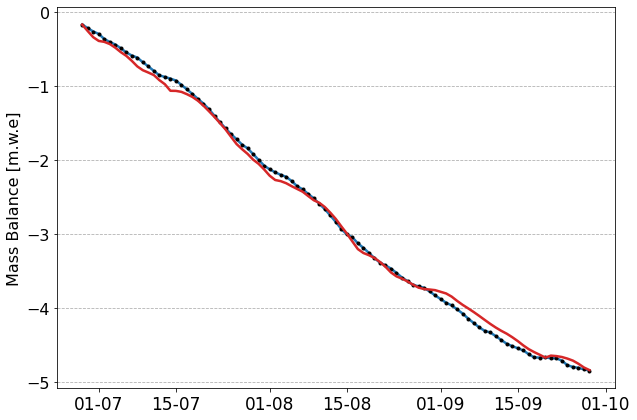

0.0005142192819402309
   station  slope_bias
0     1001   -0.001957
1     1008    0.002628
2     1003    0.003264
3     1007    0.002777
4     1006    0.001885
5     1002    0.000514


In [8]:
# getting the bias

global fig1, ax1, plot_rate

bias_only= True

years = [2019, 2020, 2021]
stations = [1001, 1008, 1003, 1007, 1006, 1002]
    
slope_bias = []
station_bias = []
for station in stations:
    for year in years:
        clim_cutted, interpolated_df, mean_bias_y, delta_grad = get_bias(station, year, visualize=True)
        slope_bias.append(delta_grad)
    mean_slope_bias = np.nanmean(slope_bias)
    print(mean_slope_bias) 
    station_bias.append(mean_slope_bias)
bias_df = pd.DataFrame({'station': stations, 'slope_bias': station_bias})
print(bias_df)


In [ ]:
plot_rate = True
bias_only = True
years = [2021]
d00 = 210
d10 = 230
names = ['FIN top', 'FIN bot.', 'PLM', 'RHO top', 'RHO mid.', 'RHO bot.']
stations = [1001, 1008, 1003, 1007, 1006, 1002]

for i in range(4):
    d0 = d00 + i*10
    d1 = d10 + i*10
    df_biases = pd.DataFrame()

    for year in years:
        if bias_only:
            fig1, ax1 = plt.subplots(figsize=(10, 7))    
        for station in stations:
            bias_station = bias_df[bias_df['station'] == station]['slope_bias'].values[0]
            #print(bias_station)
            bias_rate = get_bias_clim(station, year, mean_slope_bias=bias_station, d0=d0, d1=d1)
            name, color = station_name(station)
            df_temp = pd.DataFrame({name: bias_rate}) 
            #print(df_temp)
            df_biases = pd.concat([df_biases, df_temp], axis=1)
            
            #plt.hist(bias_rate)
            #plt.show()
            
        if bias_only:
            plt.xlabel('Day of Year')
            if plot_rate:
                plt.ylabel('Diff. Holfuy - Clim. [m.w.e/d]')
            else:
                plt.ylabel('Diff. Holfuy - Clim. [m.w.e]')
            plt.title('Year: ' + str(year))
            plt.fill_between(np.arange(d0-2,d1+2), 0, -0.01, alpha=0.1, color='tab:green')
            plt.fill_between(np.arange(d0-2,d1+2), 0, 0.01, alpha=0.1, color='tab:green')
            plt.fill_between(np.arange(d0-2,d1+2), -0.01, -0.02, alpha=0.1, color='yellow')
            plt.fill_between(np.arange(d0-2,d1+2), 0.01, 0.02, alpha=0.1, color='yellow')
            plt.fill_between(np.arange(d0-2,d1+2), -0.02, -0.03, alpha=0.1, color='orange')
            plt.fill_between(np.arange(d0-2,d1+2), 0.02, 0.03, alpha=0.1, color='orange')
            plt.fill_between(np.arange(d0-2,d1+2), -0.03, -0.06, alpha=0.1, color='tab:red')
            plt.fill_between(np.arange(d0-2,d1+2), 0.03, 0.06, alpha=0.1, color='tab:red')
            plt.grid(True, axis='y', linestyle='--')
            plt.legend()
            plt.show()
        
#for i, name in enumerate(names):
#    fig, ax = plt.subplots(figsize=(10, 7)) 
#    sns.regplot(x=df_biases[names[i]], y=df_biases[names[i+1]])
#    try:
#        (r, p) = pearsonr(df_biases[names[i]].dropna(), df_biases[names[i+1]].dropna())
#        fig.text(0.25, 0.13, r)
#    except:
#        pass
#    plt.show()
#    if i==len(names)-2:
#        break
        
    corr = df_biases.corr()
    mask_ut=np.tril(np.ones((corr.shape))).astype(bool)
    sns.heatmap(corr, mask=~mask_ut, cmap='Greens', vmin=0, annot=True)

In [ ]:
plot_rate = False
bias_only = True
years = [2019]
d0 = 228 -20
d1 = 258 -20

df_biases = pd.DataFrame()

for year in years:
    if bias_only:
        fig1, ax1 = plt.subplots(figsize=(10, 7))    
    for station in stations:
        bias_station = bias_df[bias_df['station'] == station]['slope_bias'].values[0]
        #print(bias_station)
        bias_rate = get_bias_clim(station, year, mean_slope_bias=bias_station, d0=d0, d1=d1)
        name, color = station_name(station)
        df_temp = pd.DataFrame({name: bias_rate}) 
        #print(df_temp)
        df_biases = pd.concat([df_biases, df_temp], axis=1)
    
    if bias_only:
        plt.xlabel('Day of Year')
        if plot_rate:
            plt.ylabel('Diff. Holfuy - Clim. [m.w.e/d]')
        else:
            plt.ylabel('Diff. Holfuy - Clim. [m.w.e]')
        plt.title('Year: ' + str(year))
        plt.grid(True, axis='y', linestyle='--')
        plt.legend()
        plt.show()
        
names = ['FIN top', 'FIN bot.', 'PLM', 'RHO top', 'RHO mid.', 'RHO bot.']
#for i, name in enumerate(names):
    #fig, ax = plt.subplots(figsize=(10, 7)) 
    #sns.regplot(x=df_biases[names[i]], y=df_biases[names[i+1]])
    #try:
    #    (r, p) = pearsonr(df_biases[names[i]].dropna(), df_biases[names[i+1]].dropna())
    #    fig.text(0.25, 0.13, r)
    #except:
    #    pass
    #plt.show()
    #if i==len(names)-2:
    #    break
        
corr = df_biases.corr()
mask_ut=np.tril(np.ones((corr.shape))).astype(bool)
sns.heatmap(corr, mask=~mask_ut, cmap='Greens', vmin=0., annot=True)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


[160. 180. 200. 220. 240. 260. 280.]


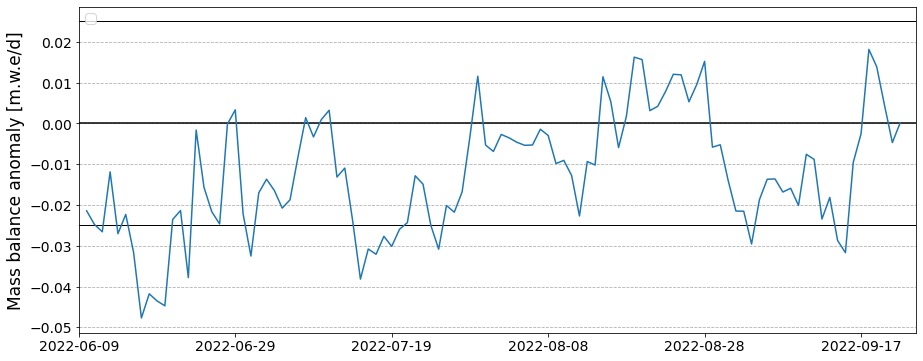

3
5
7
9
11


,mean
160,NaN
161,-0.021423
162,-0.024770
163,-0.026553
164,-0.011871
...,...
261,0.018146
262,0.013896
263,0.004438
264,-0.004687


In [9]:
#qui
plot_rate = True
bias_only = True
do_smooth = False

years = [2022]#, 2020, 2021]
#stations = [1001, 1008, 1003, 1007, 1006, 1002]
stations = [1003, 1007, 1008]
d0 = 210 - 50
d1 = 265 #+10


df_biases_all = None
df_mean_all = None
df_mean=None
df_biases = None

for year in years:
    del df_mean, df_biases
    df_biases = pd.DataFrame(index=np.arange(d0,d1,1))
    if bias_only:
        fig1, ax1 = plt.subplots(figsize=(15, 6))    
    for station in stations:
        bias_station = bias_df[bias_df['station'] == station]['slope_bias'].values[0]
        #print(bias_station)
        doys, bias_rate = get_bias_clim(station, year, mean_slope_bias=bias_station, d0=d0, d1=d1)
        #print(doys, len(bias_rate))
        name, color = station_name(station)
        
        if do_smooth:
            df_temp = pd.DataFrame({name: bias_rate.rolling(2).sum()})
            #df_temp = df_temp.set_index('doy')
        else:
            df_temp = pd.DataFrame({'doy': doys, name: bias_rate})
            df_temp = df_temp.set_index('doy')
            #df_temp = df_temp.rolling(5).sum()
        #print(df_temp)
        df_biases = pd.concat([df_biases, df_temp], axis=1)
    
    if bias_only:
        #plt.xlabel('Day of Year')
        if plot_rate:
            pass
            #
        else:
            plt.ylabel('Diff. Holfuy - Clim. [m.w.e]')
        #try:    
        #    plt.plot(np.arange(d0,d1+1,1), df_biases.mean(axis=1), label='mean', linewidth=3, color='red',
        #            marker='.', markerfacecolor='black', markeredgecolor='black')
        #except:
        #    plt.plot(np.arange(d0,d1,1), df_biases.mean(axis=1), label='mean', linewidth=3, color='red',
        #            marker='.', markerfacecolor='black', markeredgecolor='black')
            
        plt.plot([d0-2,d1+2],[0,0],color='black')
        plt.plot([d0-2,d1+2],[0.025,0.025],color='black', linewidth=1)
        plt.plot([d0-2,d1+2],[-0.025, -0.025],color='black', linewidth=1)
        #plt.title('Year: ' + str(year))
        plt.grid(True, axis='y', linestyle='--')
        ax1.set_xlim([160, 267])
        #ax1.set_ylim([-0.09, 0.065])
        print(ax1.get_xticks())
        
        xtime_h = np.arange(dt.datetime(year,6,9), dt.datetime(year,10,7), dt.timedelta(days=20))
        rounded = xtime_h.astype('datetime64[D]')        
        ax1.set_xticks(np.arange(160, 280, 20), labels=rounded)
        
        #for a in ax1.flatten():
        ax1.tick_params(axis='both', which='major', labelsize=14)
        plt.ylabel('Mass balance anomaly [m.w.e/d]', fontsize=17)
        plt.legend(loc='upper left', fontsize=13)
        #plt.savefig('C:\\Users\\Aaron\\Documents\\pubblications\\paper1_anomalies\\writing\\glacier_anomalies\\pictures\\anomalies_2019.png')
        df_biases_all = pd.concat([df_biases_all, df_biases], axis=1)
    
    df_mean = pd.DataFrame({'mean': df_biases.mean(axis=1)})
    df_biases = pd.concat([df_biases, df_mean], axis=1)
    plt.plot(df_mean)
    plt.show()
    
    if df_mean_all is None:
        df_mean_all = df_mean
    else:
        df_mean_all = pd.concat([df_mean_all, df_mean], axis=0, ignore_index=True)
        #df_mean_all = df_mean_all.reset_index()
        #df_biases = df_biases.rename(columns = {0: 'mean'}, inplace = True)
        
names = ['FIN2', 'FIN1', 'PLM', 'RHO3', 'RHO2', 'RHO1']
#for i, name in enumerate(names):
#    fig, ax = plt.subplots(figsize=(10, 7)) 
#    sns.regplot(x=df_biases[names[i]], y=df_biases[names[i+1]])
#    try:
#        (r, p) = pearsonr(df_biases[names[i]].dropna(), df_biases[names[i+1]].dropna())
#        fig.text(0.25, 0.13, r)
#    except:
#        pass
#    plt.show()
#    if i==len(names)-2:
#        break
        
#corr = df_biases.corr()
#mask_ut=np.tril(np.ones((corr.shape))).astype(bool)

#annot_kws={'fontsize':13}

#swarm_plot = sns.heatmap(corr, mask=~mask_ut, cmap='Greens', vmin=0., annot=True, annot_kws= annot_kws)
#swarm_plot.figure.axes[-1].yaxis.label.set_size(18)
#sns.set(font_scale=0.8)
#fig = swarm_plot.get_figure()
#fig.savefig('C:\\Users\\Aaron\\Documents\\pubblications\\paper1_anomalies\\writing\\glacier_anomalies\\pictures\\corr_matrix_2021_wmean.png') 
#plt.show()

#ds_corr = corr.to_xarray()

# AGGREGATION
step = [3, 5, 7, 9, 11]

for ste in step: 
    print(ste)
    df_aggregated = pd.DataFrame()
    for i in df_biases.index:
        df_biases_copy = df_biases.copy()
        #if i<=171:
        #    pass
        if i%ste!=0:
            pass
        else:   
            indexes_2drop = df_biases_copy[(df_biases_copy.index<i-((ste-1)/2)) | (df_biases_copy.index>i+((ste-1)/2))].index
            df_biases_copy = df_biases_copy.drop(indexes_2drop)
            df_biases_copy = df_biases_copy.sum(axis=0).to_frame().T
            df_aggregated = pd.concat([df_aggregated, df_biases_copy], axis=0)
    df_aggregated = df_aggregated.reset_index()

    df_aggregated = df_aggregated.drop('index', axis=1)
    df_aggregated = df_aggregated.replace(0.0, np.nan)

    corr = df_aggregated.corr()
    #print(corr)
    #ds_corr = xarray.concat([ds_corr, corr.to_xarray()], dim='aggregation')
    
    mask_ut=np.tril(np.ones((corr.shape))).astype(bool)

    annot_kws={'fontsize':13}

    #swarm_plot = sns.heatmap(corr, mask=~mask_ut, cmap='Greens', vmin=0., annot=True, annot_kws= annot_kws)
    #swarm_plot.figure.axes[-1].yaxis.label.set_size(18)
    #sns.set(font_scale=1.2)
    #fig = swarm_plot.get_figure()
    #fig.savefig('C:\\Users\\Aaron\\Documents\\pubblications\\paper1_anomalies\\writing\\glacier_anomalies\\pictures\\corr_matrix_lab.png') 
df_mean_all

In [ ]:
fig, ax = plt.subplots(figsize=(10, 7)) 
sns.regplot(x=df_biases['RHO3'], y=df_biases['FIN2'])
try:
    (r, p) = pearsonr(df_biases['RHO3'].dropna(), df_biases['FIN2'].dropna())
    fig.text(0.25, 0.13, r)
except:
        pass

# plot of the anomalies

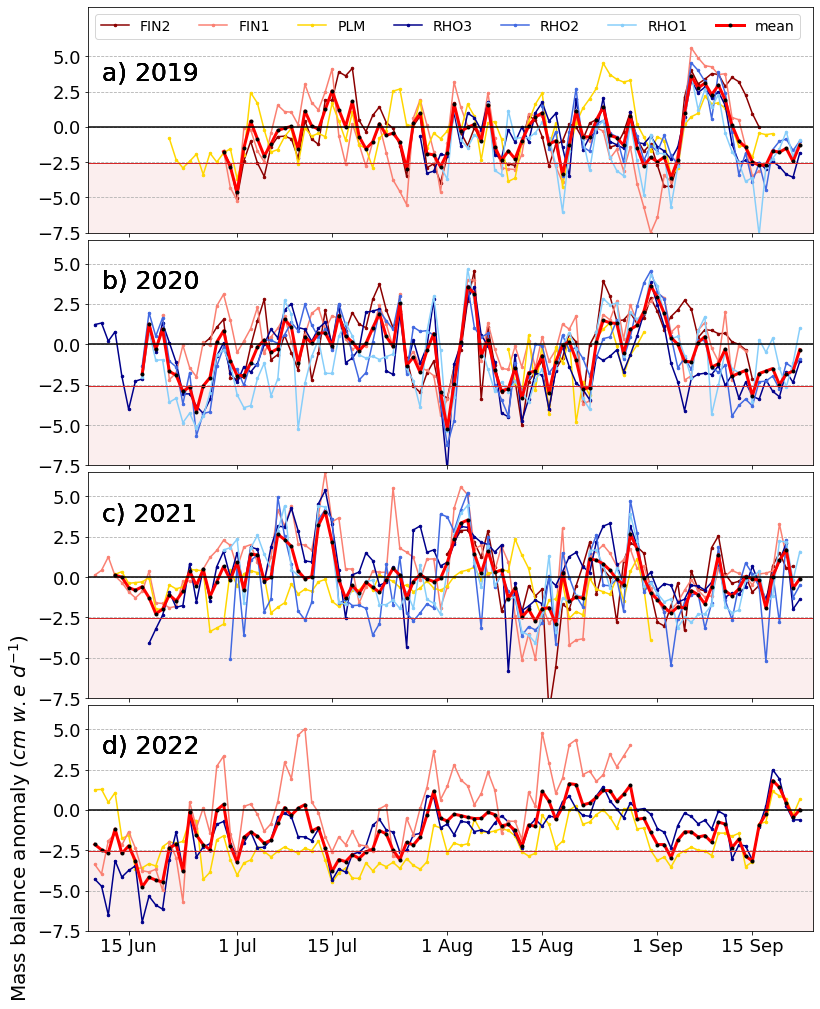

In [21]:
#test
plot_rate = True
do_smooth = False
visualize = False

years = [2019, 2020, 2021, 2022]
stations = [1001, 1008, 1003, 1007, 1006, 1002]
#stations = [1003, 1007, 1008]
d0 = 210 - 50
d1 = 265 #+10



fig, axes = plt.subplots(4,1, figsize=(13, 17), sharex=True) 
fig.subplots_adjust(hspace=0.03)

for count, year in enumerate(years):
    if year==2022:
        stations = [1003, 1007, 1008]
    
    #if bias_rate is not None:
    #    del(bias_rate)
    #if df_biases is not None:
    #    del(df_biases)
        
    df_biases = pd.DataFrame(index=np.arange(d0,d1,1))
    
    #ax = fig1.add_subplot(4, 1, count+1)#, sharex='limits')    
    for station in stations:
        bias_station = bias_df[bias_df['station'] == station]['slope_bias'].values[0]
        #print(bias_station)
        doys, bias_rate = get_bias_clim(station, year, mean_slope_bias=bias_station, d0=d0, d1=d1)
        name, color = station_name(station)
        bias_rate=bias_rate*100
        
        axes[count].plot(doys, bias_rate, label=name, color=color, marker='.', markerfacecolor=color, markeredgecolor=color, markersize=5)
        
        if do_smooth:
            df_temp = pd.DataFrame({name: bias_rate.rolling(2).sum()})
            #df_temp = df_temp.set_index('doy')
        else:
            df_temp = pd.DataFrame({'doy': doys, name: bias_rate})
            df_temp = df_temp.set_index('doy')
            #df_temp = df_temp.rolling(5).sum()
        #print(df_temp)
        df_biases = pd.concat([df_biases, df_temp], axis=1)
        if year==2019:
            df_biases= df_biases[df_biases.index>=180]
        if year==2020:
            df_biases= df_biases[df_biases.index>=168]
        if year==2021:
            df_biases= df_biases[df_biases.index>=164]
    
    if bias_only:
        #plt.xlabel('Day of Year')
        if plot_rate:
            pass
            #
        else:
            plt.ylabel('Diff. Holfuy - Clim. [m.w.e]')
        #try:    
        axes[count].plot(df_biases.index, df_biases.mean(axis=1), label='mean', linewidth=3, color='red',
                    marker='.', markerfacecolor='black', markeredgecolor='black')
        #except:
        #    axes[count].plot(df_biases.index, df_biases.mean(axis=1), label='mean', linewidth=3, color='red',
        #            marker='.', markerfacecolor='black', markeredgecolor='black')
            
        axes[count].plot([d0-2,d1+2],[0,0],color='black')
        #axes[count].plot([d0-2,d1+2],[2.5,2.5],color='tab:blue', linewidth=1)
        axes[count].plot([d0-2,d1+2],[-2.55, -2.55],color='tab:red', linewidth=1)
        #plt.title('Year: ' + str(year))
        axes[count].grid(True, axis='y', linestyle='--')
        axes[count].set_xlim([160, 267])
        axes[count].set_ylim([-7.5, 6.5])
        axes[0].set_ylim([-7.5, 8.5])
        axes[0].set_yticks(np.arange(-7.5,7.5,2.5))
        #print(ax1.get_xticks())
        axes[0].legend(loc='upper left', fontsize=14, ncol=7)
        xtime_h = np.arange(dt.datetime(year,6,9), dt.datetime(year,10,7), dt.timedelta(days=20))
        rounded = xtime_h.astype('datetime64[D]')  
        axes[3].set_xticks([257-91, 273-91, 287-91, 304-91, 318-91, 335-91, 349-91], ['15 Jun', '1 Jul', '15 Jul', '1 Aug', '15 Aug', '1 Sep', '15 Sep'])
        
        fig.text(0.14, 0.82, 'a) 2019', fontsize=25)
        fig.text(0.14, 0.65, 'b) 2020', fontsize=25)
        fig.text(0.14, 0.46, 'c) 2021', fontsize=25)
        fig.text(0.14, 0.27, 'd) 2022', fontsize=25)


        #axes[3].set_xticks(np.arange(160, 280, 20), labels=['9 June'])
        #axes[3].xaxis.set_major_formatter(DateFormatter("%d-%m"))
        
        #for a in ax1.flatten():
        axes[count].tick_params(axis='both', which='major', labelsize=18)
        axes[count].fill_between(np.arange(d0-2,d1+5), -9, -2.55, alpha=0.08, color='tab:red')
        #axes[count].fill_between(np.arange(d0-2,d1+5), 2.5, 9, alpha=0.08, color='tab:blue')
        
plt.ylabel('Mass balance anomaly ($cm$ $w.e$ $d^{-1}$)', fontsize=20)
plt.savefig('C:\\Users\\Aaron\\Documents\\pubblications\\paper1_anomalies\\writing\\glacier_anomalies\\pictures\\anomalies_all.png')
plt.show()
        
df_mean = pd.DataFrame({'mean': df_biases.mean(axis=1)})
df_biases = pd.concat([df_biases, df_mean], axis=1)
#df_biases = df_biases.rename(columns = {0: 'mean'}, inplace = True)
        
names = ['FIN2', 'FIN1', 'PLM', 'RHO3', 'RHO2', 'RHO1']

In [ ]:
fig, ax = plt.subplots(figsize=(7, 7)) 

ds_corr = ds_corr.assign_coords({"aggregation": [1, 3, 5, 7, 9, 11]})
#ds_corr.sel(index='FIN2').FIN1.plot(ax=ax, label='F1-F2', color='gold')
#ds_corr.sel(index='FIN2').PLM.plot(ax=ax, color='darkred', label='F2-P')
#ds_corr.sel(index='FIN2').RHO1.plot(ax=ax, label='F2-R1', color='darkgreen')
#ds_corr.sel(index='FIN2').RHO2.plot(ax=ax, label='F2-R2', color='green')
#ds_corr.sel(index='FIN2').RHO3.plot(ax=ax, label='F2-R3', color='limegreen')
ds_corr.sel(index='FIN2')['mean'].plot(ax=ax, label='FIN2', color='darkred')

#ds_corr.sel(index='FIN1').PLM.plot(ax=ax,color='red', label='F1-P')
#ds_corr.sel(index='FIN1').RHO1.plot(ax=ax, label='F1-R1', color='lightgreen')
#ds_corr.sel(index='FIN1').RHO2.plot(ax=ax, label='F1-R2', color='palegreen')
#ds_corr.sel(index='FIN1').RHO3.plot(ax=ax, label='F1-R3', color='yellowgreen')
ds_corr.sel(index='FIN1')['mean'].plot(ax=ax, label='FIN1', color='salmon')


#ds_corr.sel(index='PLM').RHO1.plot(ax=ax, color='tomato', label='P-R1')
#ds_corr.sel(index='PLM').RHO2.plot(ax=ax, color='salmon', label='P-R2')
#ds_corr.sel(index='PLM').RHO3.plot(ax=ax, color='lightsalmon', label='P-R3')
#ds_corr.sel(index='PLM')['mean'].plot(ax=ax, color='gold', label='PLM')


#ds_corr.sel(index='RHO1').RHO2.plot(ax=ax, label='R1-R2', color='darkblue')
#ds_corr.sel(index='RHO1').RHO3.plot(ax=ax, label='R1-R3', color='blue')
ds_corr.sel(index='RHO1')['mean'].plot(ax=ax, label='RHO1', color='lightskyblue')

#ds_corr.sel(index='RHO2').RHO3.plot(ax=ax, label='R2-R3', color='deepskyblue')
ds_corr.sel(index='RHO2')['mean'].plot(ax=ax, label='RHO2', color='royalblue')

ds_corr.sel(index='RHO3')['mean'].plot(ax=ax, label='RHO3', color='darkblue')

plt.grid(True, axis='y', linestyle='--')
plt.tick_params(labelsize = 18)
plt.ylabel('Correlation [-]', fontsize=20)
plt.xlabel('Aggregation [day]', fontsize=20)
plt.ylim([0,1])
plt.legend(bbox_to_anchor =(1.1, 1.25), fontsize=16, ncol=6)
#fig.savefig('C:\\Users\\Aaron\\Documents\\pubblications\\paper1_anomalies\\writing\\glacier_anomalies\\pictures\\aggregation_correlation2020.png') 

In [ ]:
# case with +- thresh
#ds_corr = ds_corr.assign_coords({"aggregation": [1, 3, 5, 7, 9, 11]})
df_biases#.aggregation
count=0
count_anomaly_nan = 0
count_normal = 0
count_pos = 0
count_neg = 0
count_other = 0
anomalies_all = []
extreme_thresh_pos = 0.025
extreme_thresh_neg = -0.025

for index, row in df_biases.iterrows() :
    for anomaly in row:
        anomalies_all.append(anomaly)
        if np.isnan(anomaly):
            count_anomaly_nan+=1
        elif anomaly >= extreme_thresh_neg and anomaly<= extreme_thresh_pos:
            count_normal+=1
        elif anomaly > extreme_thresh_pos:
            count_pos+=1
        elif anomaly < extreme_thresh_neg:
            count_neg+=1
        else:
            count_other+=1
            
            
            
            
        #print('Data at index', index)
        #print(col)
        count+=1
print('mean anomaly overall: ', np.nanmean(anomalies_all))
print('nan anomalies: ', count_anomaly_nan)
print('normal anomalies: ', count_normal)
print('positive anomalies: ', count_pos)
print('negative anomalies: ', count_neg)
print('count other things: ',count_other)
print('percentage neg/tot: ', count_neg/(count_normal+count_pos+count_neg))
print('percentage pos/tot: ', count_pos/(count_normal+count_pos+count_neg))
print('percentage normal/tot: ', count_normal/(count_normal+count_pos+count_neg))


In [ ]:
# case with 0 - -thresh

count=0
count_anomaly_nan = 0
count_normal = 0
count_pos = 0
count_neg = 0
count_other = 0
anomalies_all = []
extreme_thresh_neg = -0.0255

for index, row in df_mean_all.iterrows() :
    for anomaly in row:
        print(anomaly)
        
        if np.isnan(anomaly):
            count_anomaly_nan+=1
        elif anomaly >= extreme_thresh_neg and anomaly<= 0:
            count_normal+=1
            anomalies_all.append(anomaly)
        elif anomaly < extreme_thresh_neg:
            anomalies_all.append(anomaly)
            count_neg+=1
        else:
            count_other+=1
            
            
            
            
        #print('Data at index', index)
        #print(col)
        count+=1
print('mean anomaly overall: ', np.nanmean(anomalies_all))
print('nan anomalies: ', count_anomaly_nan)
print('normal anomalies: ', count_normal)
print('negative anomalies: ', count_neg)
print('count other things: ',count_other)
print('percentage neg/tot: ', count_neg/(count_normal+count_neg))
print('percentage normal/tot: ', count_normal/(count_normal+count_neg))

np.nanquantile(anomalies_all, [0.15, 0.9])
#plt.hist(anomalies_all, bins=20)

In [ ]:
med = df_biases.std(axis=1).mean()
low = df_biases.quantile(
    q=0.05,                      # The percentile to calculate
    axis=1,                     # The axis to calculate the percentile on
    numeric_only=True,          # To calculate only for numeric columns
    interpolation='linear'      # The type of interpolation to use when the quantile is between 2 values
)
up = df_biases.quantile(
    q=0.95,                      # The percentile to calculate
    axis=1,                     # The axis to calculate the percentile on
    numeric_only=True,          # To calculate only for numeric columns
    interpolation='linear'      # The type of interpolation to use when the quantile is between 2 values
)
print(np.mean(low))
print(np.mean(up))
((up-low)/2).mean()

In [ ]:
plot_rate = True
bias_only = True
do_smooth = False
years = [2020]
d0 = 220
d1 = 250

df_biases = pd.DataFrame()

for year in years:
    if bias_only:
        fig1, ax1 = plt.subplots(figsize=(10, 7))    
    for station in stations:
        bias_station = bias_df[bias_df['station'] == station]['slope_bias'].values[0]
        #print(bias_station)
        bias_rate = get_bias_clim(station, year, mean_slope_bias=bias_station, d0=d0, d1=d1)
        name, color = station_name(station)
        if do_smooth:
            df_temp = pd.DataFrame({name: smooth(bias_rate,3)})
        else:
            df_temp = pd.DataFrame({name: bias_rate}) 
        #print(df_temp)
        df_biases = pd.concat([df_biases, df_temp], axis=1)
    
    if bias_only:
        plt.xlabel('Day of Year')
        if plot_rate:
            plt.ylabel('Diff. Holfuy - Clim. [m.w.e/d]')
        else:
            plt.ylabel('Diff. Holfuy - Clim. [m.w.e]')
        plt.title('Year: ' + str(year))
        plt.legend()
        plt.show()
        
names = ['FIN top', 'FIN bot.', 'PLM', 'RHO top', 'RHO mid.', 'RHO bot.']
#for i, name in enumerate(names):
#    fig, ax = plt.subplots(figsize=(10, 7)) 
#    sns.regplot(x=df_biases[names[i]], y=df_biases[names[i+1]])
#    try:
#        (r, p) = pearsonr(df_biases[names[i]].dropna(), df_biases[names[i+1]].dropna())
#        fig.text(0.25, 0.13, r)
#    except:
#        pass
#    plt.show()
#    if i==len(names)-2:
#        break
        
corr = df_biases.corr()
mask_ut=np.tril(np.ones((corr.shape))).astype(bool)
sns.heatmap(corr, mask=~mask_ut, cmap='Greens', vmin=0., annot=True)

In [ ]:
bias_only= True
stations = [1001, 1002, 1003, 1006, 1007, 1008]

for year in years:
    if bias_only:
        fig1, ax1 = plt.subplots(figsize=(10, 7))    
    for station in stations:
        get_bias_clim(station, year, mean_slope_bias)
        

    if bias_only:
        plt.xlabel('Day of Year')
        plt.ylabel('Mass Balance [m.w.e]')
        plt.legend()
        plt.show()

# Results: algorithm performances
1) converting from 20min to daily resolution
2) load data and plot 

In [ ]:
# 1)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt

path_automatic_readings = 'C:\\Users\\Aaron\\Documents\\pubblications\\paper1_anomalies\\data\\holfuy\\2020\\1008_mT_Hist_2020-06-18_05-24_2020-09-14_19-48.csv'

auto_readings = pd.read_csv(path_automatic_readings)

start_year = int(path_automatic_readings.split('\\')[-1].split('_')[3].split('-')[0])
start_month = int(path_automatic_readings.split('\\')[-1].split('_')[3].split('-')[1])
start_day = int(path_automatic_readings.split('\\')[-1].split('_')[3].split('-')[2])
start_hour = int(path_automatic_readings.split('\\')[-1].split('_')[4].split('-')[0])
start_minute = int(path_automatic_readings.split('\\')[-1].split('_')[4].split('-')[1])

end_year = int(path_automatic_readings.split('\\')[-1].split('_')[5].split('-')[0])
end_month = int(path_automatic_readings.split('\\')[-1].split('_')[5].split('-')[1])
end_day = int(path_automatic_readings.split('\\')[-1].split('_')[5].split('-')[2])
end_hour = int(path_automatic_readings.split('\\')[-1].split('_')[6].split('-')[0])
end_minute = int(path_automatic_readings.split('\\')[-1].split('_')[6].split('-')[1].split('.')[0])


start_date = pd.Timestamp(year=start_year, month=start_month, day=start_day, hour=start_hour, minute=start_minute)
end_date = pd.Timestamp(year=end_year, month=end_month, day=end_day, hour=end_hour, minute=end_minute)

print(start_date, end_date)

#initial_date_str = manual_readings['initial_date'].tolist()
#final_date_str = manual_readings['final_date'].tolist()

# displacements mT_Hist
time_delta = auto_readings['time[h]'].tolist()
time = []
for t in time_delta:
    time.append(start_date + pd.Timedelta(hours=t))

auto_readings = pd.DataFrame({'date': time, 'dh': auto_readings['displacement rate [cm]'].tolist()}) #data=[[time,auto_readings['displacement rate [cm]'].tolist()]], columns=['time', 'displ'])

daily_displ = auto_readings.groupby(pd.Grouper(key='date', freq='1d')).sum().reset_index()

#initial_date = []
#final_date = []
#periodic_sum = []
#periodic_sum_mS = []
#periodic_sum_fin = []

#for idx, (init,fin) in enumerate(zip(initial_date_str, final_date_str)):
#    temp_sum = 0
#    temp_sum_mS = 0
#    temp_sum_fin = 0
#    #print('init', init)
#    y1 = int(init.split('.')[2])
#    m1 = int(init.split('.')[1])
#    d1 = int(init.split('.')[0])
#    y2 = int(fin.split('.')[2])
#    m2 = int(fin.split('.')[1])
#    d2 = int(fin.split('.')[0])

#    initial_date.append(pd.Timestamp(year=y1, month=m1, day=d1))
#    final_date.append(pd.Timestamp(year=y2, month=m2, day=d2))

#    interval = pd.Interval(pd.Timestamp(year=y1, month=m1, day=d1), pd.Timestamp(year=y2, month=m2, day=d2))
#    print(interval)

#    for date, disp in zip(daily_displ['date'].tolist(), daily_displ['dh'].tolist()):
#        if date in interval:
#            temp_sum += disp

#    periodic_sum.append(temp_sum)

# plot cumulative displacements
plt.plot(daily_displ['date'].tolist(), np.cumsum(daily_displ['dh'].tolist()), label='automatic mT')
plt.legend()
plt.show()
daily_displ['dh'] = daily_displ['dh'].div(100)
#daily_displ.to_csv('C:\\Users\\Aaron\\Documents\\pubblications\\paper1_anomalies\\data\\holfuy\\2020\\1008_abl_sum_final.csv', index=False)  # , columns=column_names)

print(np.max(np.cumsum(daily_displ['dh'].tolist())))

In [ ]:
# 2)
# load automatic readings
auto_readings_1002_19 = import_holfuy('C:\\Users\\Aaron\\Documents\\pubblications\\paper1_anomalies\\data\\holfuy\\2019\\1002_abl_sum_final.csv', format='csv_2021')
auto_readings_1002_20 = import_holfuy('C:\\Users\\Aaron\\Documents\\pubblications\\paper1_anomalies\\data\\holfuy\\2020\\1002_abl_sum_final.csv', format='csv_2021')
auto_readings_1002_21 = import_holfuy('C:\\Users\\Aaron\\Documents\\pubblications\\paper1_anomalies\\data\\holfuy\\2021\\final_readings_ablation\\1002_abl_sum.csv', format='csv_2021')

# load manual readings
manual_readings_1002_19 = import_holfuy(station=1002, year=2019, format='standard_point')
manual_readings_1002_20 = import_holfuy(station=1002, year=2020, format='standard_point')
manual_readings_1002_20['mb_we'] = manual_readings_1002_20['mb_we'].shift(periods=1)
manual_readings_1002_20 = manual_readings_1002_20.dropna()

#manual_readings_1002_20 = manual_readings_1002_20[manual_readings_1002_20['date1'] <= '2020-09-02']

manual_readings_1002_21 = pd.read_excel('C:/Users/Aaron/Documents/pubblications/paper1_anomalies/data/holfuy/2021/holfuy_manual_readings_2021/matthias/rho1002_p9_holfuy2021.xlsx',
                                       skiprows=4)
manual_readings_1002_21 = manual_readings_1002_21[['date', 'mb[m.w.e]']]
manual_readings_1002_21 = manual_readings_1002_21.dropna()

print(auto_readings_1002_19)
print(manual_readings_1002_19)


# plot

#fig params
lw = 2
s_point = 15
s_cross = 40
fig, axs = plt.subplots(3,2, figsize=(12, 8), gridspec_kw={'width_ratios': [5, 1]})

axs[0,0].plot(auto_readings_1002_19['date'].values, -np.cumsum(auto_readings_1002_19['dh'].values)-0.09-0.045, label='auto', color='tab:blue', linewidth=lw)
axs[0,0].scatter(manual_readings_1002_19['date0'].values, np.cumsum(manual_readings_1002_19['mb_we'].values/900), label='manual', color='red', marker='.', s=s_point)
axs[0,0].scatter([pd.Timestamp('2019/07/27'), pd.Timestamp('2019/10/03')], [0, -3.88], 
                 marker='x', color='black', label='in-situ', s=s_cross)
axs[0,0].text(pd.Timestamp('2019/10/01'), -1.7, 'a)', fontsize=34)

axs[1,0].plot(auto_readings_1002_20['date'].values, -np.cumsum(auto_readings_1002_20['dh'].values), label='auto', color='tab:blue', linewidth=lw)
axs[1,0].scatter(manual_readings_1002_20['date0'].values, np.cumsum(manual_readings_1002_20['mb_we'].values/900), label='manual', color='red', marker='.', s=s_point)
axs[1,0].scatter([pd.Timestamp('2020/06/15'), pd.Timestamp('2020/07/29'), pd.Timestamp('2020/09/24')], [0, -3.56, -6.66], 
            marker='x', color='black', label='in-situ', s=s_cross)
axs[1,0].text(pd.Timestamp('2020/09/21'), -1.7, 'b)', fontsize=34)

axs[2,0].plot(auto_readings_1002_21['date'].values, -np.cumsum(auto_readings_1002_21['dh'].values), label='auto', color='tab:blue', linewidth=lw)
axs[2,0].scatter(manual_readings_1002_21['date'].values, -(manual_readings_1002_21['mb[m.w.e]'].values/100), label='manual', color='red', marker='.', s=s_point)
axs[2,0].scatter([pd.Timestamp('2021/06/28'), pd.Timestamp('2021/08/06'), pd.Timestamp('2021/08/28'), pd.Timestamp('2021/09/29')], [0, -2.25, -3.96, -5.2], 
            marker='x', color='black', label='in-situ', s=s_cross)
axs[2,0].text(pd.Timestamp('2021/09/27'), -1.7, 'c)', fontsize=34)

# calculate daily errors
manual_readings_1002_19 = interpolate_manual_df(manual_readings_1002_19)
manual_readings_1002_19 = manual_readings_1002_19[manual_readings_1002_19['date'] >= '2019-07-30']
auto_readings_1002_19 = auto_readings_1002_19[auto_readings_1002_19['date'] <= '2019-10-02']
errors_19 = auto_readings_1002_19['dh'].values + manual_readings_1002_19['mb[m.w.e]'].values/900

manual_readings_1002_20 = interpolate_manual_df(manual_readings_1002_20)
auto_readings_1002_20 = auto_readings_1002_20[auto_readings_1002_20['date'] >= '2020-06-16']
auto_readings_1002_20 = auto_readings_1002_20[auto_readings_1002_20['date'] <= '2020-09-22']
errors_20 = auto_readings_1002_20['dh'].values + manual_readings_1002_20['mb[m.w.e]'].values/900

xtime_h = manual_readings_1002_21['date'].values
rounded = xtime_h.astype('datetime64[s]')
xtime_h = [x.astype(dt.datetime) for x in rounded]
periodic_sum = []
days_between = []

for i, dat in enumerate(xtime_h):
    temp_sum = 0
    
    try:
        interval = pd.Interval(pd.Timestamp(year=dat.year, month=dat.month, day=dat.day), 
                               pd.Timestamp(year=xtime_h[i+1].year, 
                                            month=xtime_h[i+1].month,
                                            day=xtime_h[i+1].day))
        days_between.append(interval.length.days)
        for date, disp in zip(auto_readings_1002_21['date'].tolist(), auto_readings_1002_21['dh'].tolist()):
            if date in interval:
                temp_sum += disp

        periodic_sum.append(temp_sum)
    except:
        print('end of array')
    
manual_readings_1002_21_rate = manual_readings_1002_21['mb[m.w.e]'].diff(periods = 1)
manual_readings_1002_21_rate = pd.DataFrame(({'date': manual_readings_1002_21['date'].values, 'mb[m.w.e]': manual_readings_1002_21_rate}))
manual_readings_1002_21_rate = manual_readings_1002_21_rate.dropna()

errors_21 = (periodic_sum-manual_readings_1002_21_rate['mb[m.w.e]'].values/100)/days_between
#plt.plot(periodic_sum)
#plt.plot(manual_readings_1002_21_rate['mb[m.w.e]'].values/100)

bp1 = axs[0,1].boxplot(errors_19*100, notch=False, bootstrap=10000, showfliers=False, showmeans=True, patch_artist = True)#,
bp1['medians'][0].set(color ='red', linewidth = 2)
bp1['means'][0].set(color='red', linewidth = 2)

bp1['boxes'][0].set_facecolor('lightblue')
axs[0,1].text(0.54, 0.1, str(round(np.median(errors_19*100),2)), fontsize=14)
axs[0,1].text(1.13, -0.25, str(round(np.mean(errors_19*100)-0.01,2)), fontsize=14)
axs[0,1].text(1.128, 0.5, 'd)', fontsize=34)


bp2 = axs[1,1].boxplot(errors_20*100, notch=False, bootstrap=10000, showfliers=False, showmeans=True, patch_artist = True)
bp2['medians'][0].set(color ='red', linewidth = 2)
bp2['boxes'][0].set_facecolor('lightblue')

axs[1,1].text(0.54, 0.2, str(round(np.median(errors_20*100),2)), fontsize=14)
axs[1,1].text(1.13, -0.45, str(round(np.mean(errors_20*100),2)), fontsize=14)
axs[1,1].text(1.15, 1, 'e)', fontsize=34)

bp2 = axs[2,1].boxplot(errors_21*100, notch=False, bootstrap=10000, showfliers=False, showmeans=True, patch_artist = True)
bp2['medians'][0].set(color ='red', linewidth = 2)
bp2['boxes'][0].set_facecolor('lightblue')

axs[2,1].text(0.53, -0.2, str(round(np.median(errors_21*100),2)), fontsize=14)
axs[2,1].text(1.13, -0.7, str(round(np.mean(errors_21*100),2)), fontsize=14)
axs[2,1].text(1.23, 0.8, 'f)', fontsize=34)


#bp = axs[2,1].boxplot((interpolate_holfuy_df(manual_readings_1002_21)['mb[m.w.e]'].values/100 - auto_readings_1002_21['dh_cs'].values[:-1])*100,
#                notch=True, bootstrap=10000, showfliers=False)
#bp['medians'][0].set(color ='red', linewidth = 2)

axs[0,1].set_yticks(np.arange(-1,1.5,0.5))
axs[1,1].set_yticks(np.arange(-2,2.5,1))
axs[2,1].set_yticks(np.arange(-2,2.5,1))

axs[0,0].set_xticks(np.arange(auto_readings_1002_19['date'].values[0],auto_readings_1002_19['date'].values[-1],dt.timedelta(days=20)))
axs[1,0].set_xticks(np.arange(auto_readings_1002_20['date'].values[0],auto_readings_1002_20['date'].values[-1],dt.timedelta(days=30)))
axs[2,0].set_xticks(np.arange(auto_readings_1002_21['date'].values[0],auto_readings_1002_21['date'].values[-1],dt.timedelta(days=30)))
axs[0,0].set_yticks(np.arange(-6,0.5,2))
axs[1,0].set_yticks(np.arange(-6,0.5,2))
axs[2,0].set_yticks(np.arange(-6,0.5,2))

#axs[0,0].set_xlim([dt.datetime(2019, 6, 12), dt.datetime(2019, 10, 5)])
#axs[1,0].set_xlim([dt.datetime(2020, 6, 12), dt.datetime(2020, 10, 5)])
#axs[2,0].set_xlim([dt.datetime(2021, 6, 12), dt.datetime(2021, 10, 5)])


axs[0,1].yaxis.tick_right()
axs[1,1].yaxis.tick_right()
axs[2,1].yaxis.tick_right()
axs[0,1].yaxis.set_label_position("right")
axs[1,1].yaxis.set_label_position("right")
axs[2,1].yaxis.set_label_position("right")

axs[0,0].set_ylim([-7,0.5])
axs[1,0].set_ylim([-7,0.5])
axs[2,0].set_ylim([-7,0.5])

axs[2,0].legend(fontsize=14, loc='lower left')
axs[0,0].grid(True, axis='y', linestyle='--')
axs[0,1].grid(True, axis='y', linestyle='--')
axs[1,0].grid(True, axis='y', linestyle='--')
axs[1,1].grid(True, axis='y', linestyle='--')
axs[2,0].grid(True, axis='y', linestyle='--')
axs[2,1].grid(True, axis='y', linestyle='--')

for a in axs.flatten():
    a.tick_params(axis='both', which='major', labelsize=14)
    #a.tick_params(axis='both', which='minor', labelsize=20)

    
fig.supylabel('Cumulative daily mass balance (m)', fontsize=16)
#axs[0,1].set_ylabel('Daily error [cm]', fontsize=14)
axs[1,1].set_ylabel('Daily error (cm)', fontsize=16)
#axs[2,1].set_ylabel('Weekly error [cm]', fontsize=14)
axs[0,1].set_title('median   mean', fontsize=14)

#plt.savefig('C:\\Users\\Aaron\\Documents\\pubblications\\paper1_anomalies\\writing\\glacier_anomalies\\pictures\\algorithm_performances_s1002.png')

plt.show()

In [ ]:
#plt.plot(manual_readings_1002_21['mb[m.w.e]'].values/90)
manual_readings_1002_21 = interpolate_manual_df(manual_readings_1002_21, key='date')
manual_readings_1002_21['mb[m.w.e]'] = manual_readings_1002_21['mb[m.w.e]'].diff(periods=1)
manual_readings_1002_21 = manual_readings_1002_21.dropna()
#auto_readings_1002_21 = auto_readings_1002_21[auto_readings_1002_21['date'] >= '2021-06-28']
#auto_readings_1002_21 = auto_readings_1002_21[auto_readings_1002_21['date'] <= '2021-09-29']
#errors_21 = auto_readings_1002_21['dh'].values - manual_readings_1002_21['mb[m.w.e]'].values/900

auto_readings_1002_21 = auto_readings_1002_21[auto_readings_1002_21['date'] >= '2021-06-30']
auto_readings_1002_21 = auto_readings_1002_21[auto_readings_1002_21['date'] <= '2021-09-29']

manual_readings_1002_21 = manual_readings_1002_21[manual_readings_1002_21['date'] >= '2021-06-30']
manual_readings_1002_21 = manual_readings_1002_21[manual_readings_1002_21['date'] <= '2021-09-29']
errors_21 = auto_readings_1002_21['dh'].values - manual_readings_1002_21['mb[m.w.e]'].values/100

plt.plot(auto_readings_1002_21['date'].values, auto_readings_1002_21['dh'].values, label='auto', color='tab:blue', linewidth=lw)
plt.plot(manual_readings_1002_21['date'].values, manual_readings_1002_21['mb[m.w.e]'].values/100, label='manual', color='red')
#plt.scatter([pd.Timestamp('2021/06/28'), pd.Timestamp('2021/08/06'), pd.Timestamp('2021/08/28'), pd.Timestamp('2021/09/29')], [0, -2.25, -3.96, -5.2], 
#            marker='x', color='black', label='in-situ', s=s_cross)
plt.legend()
print('errrors 2021: mean, median', np.mean(errors_21)*100, np.median(errors_21)*100)

In [ ]:
# load automatic readings
auto_readings_1002_19 = import_holfuy('C:\\Users\\Aaron\\Documents\\pubblications\\paper1_anomalies\\data\\holfuy\\2019\\1002_abl_sum_final.csv', format='csv_2021')
auto_readings_1002_20 = import_holfuy('C:\\Users\\Aaron\\Documents\\pubblications\\paper1_anomalies\\data\\holfuy\\2020\\1002_abl_sum_final.csv', format='csv_2021')
auto_readings_1002_21 = import_holfuy('C:\\Users\\Aaron\\Documents\\pubblications\\paper1_anomalies\\data\\holfuy\\2021\\final_readings_ablation\\1002_abl_sum.csv', format='csv_2021')

# load manual readings
manual_readings_1002_19 = import_holfuy(station=1002, year=2019, format='standard_point')
manual_readings_1002_20 = import_holfuy(station=1002, year=2020, format='standard_point')
manual_readings_1002_20['mb_we'] = manual_readings_1002_20['mb_we'].shift(periods=1)
manual_readings_1002_20 = manual_readings_1002_20.dropna()

#manual_readings_1002_20 = manual_readings_1002_20[manual_readings_1002_20['date1'] <= '2020-09-02']

manual_readings_1002_21 = pd.read_excel('C:/Users/Aaron/Documents/pubblications/paper1_anomalies/data/holfuy/2021/holfuy_manual_readings_2021/matthias/rho1002_p9_holfuy2021.xlsx',
                                       skiprows=4)
manual_readings_1002_21 = manual_readings_1002_21[['date', 'mb[m.w.e]']]
manual_readings_1002_21 = manual_readings_1002_21.dropna()

print(auto_readings_1002_19)
print(manual_readings_1002_19)

# calculate daily errors
manual_readings_1002_19 = interpolate_manual_df(manual_readings_1002_19)
manual_readings_1002_19 = manual_readings_1002_19[manual_readings_1002_19['date'] >= '2019-07-30']
auto_readings_1002_19 = auto_readings_1002_19[auto_readings_1002_19['date'] <= '2019-10-01']
errors_19 = auto_readings_1002_19['dh'].values + manual_readings_1002_19['mb[m.w.e]'].values/900

manual_readings_1002_20 = interpolate_manual_df(manual_readings_1002_20)
auto_readings_1002_20 = auto_readings_1002_20[auto_readings_1002_20['date'] >= '2020-06-16']
auto_readings_1002_20 = auto_readings_1002_20[auto_readings_1002_20['date'] <= '2020-09-21']
errors_20 = auto_readings_1002_20['dh'].values + manual_readings_1002_20['mb[m.w.e]'].values/900

manual_readings_1002_21 = interpolate_manual_df(manual_readings_1002_21, key='date')
auto_readings_1002_21 = auto_readings_1002_21[auto_readings_1002_21['date'] >= '2021-06-28']
auto_readings_1002_21 = auto_readings_1002_21[auto_readings_1002_21['date'] <= '2021-09-28']
errors_21 = auto_readings_1002_21['dh'].values - manual_readings_1002_21['mb[m.w.e]'].values/900

print('errrors 2019: mean, median', np.mean(errors_19)*100, np.median(errors_19)*100)
print('errrors 2020: mean, median', np.mean(errors_20)*100, np.median(errors_20)*100)
print('errrors 2021: mean, median', np.mean(errors_21)*100, np.median(errors_21)*100)

In [ ]:
xtime_h = manual_readings_1002_21['date'].values
rounded = xtime_h.astype('datetime64[s]')
xtime_h = [x.astype(dt.datetime) for x in rounded]
periodic_sum = []
days_between = []

for i, dat in enumerate(xtime_h):
    temp_sum = 0
    
    try:
        interval = pd.Interval(pd.Timestamp(year=dat.year, month=dat.month, day=dat.day), 
                               pd.Timestamp(year=xtime_h[i+1].year, 
                                            month=xtime_h[i+1].month,
                                            day=xtime_h[i+1].day))
        days_between.append(interval.length.days)
        for date, disp in zip(auto_readings_1002_21['date'].tolist(), auto_readings_1002_21['dh'].tolist()):
            if date in interval:
                temp_sum += disp

        periodic_sum.append(temp_sum)
    except:
        print('end of array')
    
        
manual_readings_1002_21_rate = manual_readings_1002_21['mb[m.w.e]'].diff(periods = 1)
manual_readings_1002_21_rate = pd.DataFrame(({'date': manual_readings_1002_21['date'].values, 'mb[m.w.e]': manual_readings_1002_21_rate}))
manual_readings_1002_21_rate = manual_readings_1002_21_rate.dropna()
plt.plot(periodic_sum)
plt.plot(manual_readings_1002_21_rate['mb[m.w.e]'].values/100)
plt.plot((periodic_sum-manual_readings_1002_21_rate['mb[m.w.e]'].values/100)/days_between)
print(np.mean((periodic_sum-manual_readings_1002_21_rate['mb[m.w.e]'].values/100)/days_between))
print(np.median((periodic_sum-manual_readings_1002_21_rate['mb[m.w.e]'].values/100)/days_between))

days_between

In [ ]:
#plt.boxplot(interpolate_holfuy_df(manual_readings_1002_21)['mb[m.w.e]'].values/100 - auto_readings_1002_21['dh_cs'].values[:-1])
#auto_readings_1002_21
#plt.plot(errors_20)
#interpolate_holfuy_df(manual_readings_1002_21)
#manual_readings_1002_20['mb[m.w.e]'] = manual_readings_1002_20['mb[m.w.e]'].shift(periods=13)
#plt.plot(auto_readings_1002_20['date'].values, -auto_readings_1002_20['dh'].values, label='auto')
#plt.plot(manual_readings_1002_20['date'].values, manual_readings_1002_20['mb[m.w.e]'].values/900)#, label='manual', color='tab:orange', marker='.', s=10)
#plt.scatter([pd.Timestamp('2020/06/15'), pd.Timestamp('2020/07/29'), pd.Timestamp('2020/09/24')], [0, -3.56, -6.66], 
            #marker='x', color='black', label='in-situ')
#plt.plot(interpolate_holfuy_df((manual_readings_1002_21)['mb[m.w.e]'].values/100 - auto_readings_1002_21['dh_cs'].values[:-1])*100)
manual_readings_1002_21

# Other

In [ ]:
station = 1002
year = 2021

if year == 2021:
    holfuy = import_holfuy(station=station, year=year, format='csv_2021')
    xtime_h = holfuy['date'].values
    rounded = xtime_h.astype('datetime64[s]')
    xtime_h = [x.astype(dt.datetime) for x in rounded]
    cum_mb = holfuy['mb[m.w.e]'].values
    holfuy_new = pd.DataFrame({'date': xtime_h, 'mb[m.w.e]': cum_mb})
else:
    holfuy = import_holfuy(station=station, year=year, format='standard_point')
    xtime_h = holfuy['date1'].values
    cum_mb = np.cumsum(holfuy['mb_we'].values / 1000)
    holfuy_new = pd.DataFrame({'date': xtime_h, 'mb[m.w.e]': cum_mb})
# clim
xtime_c = pd.date_range(dt.datetime(year - 1, 10, 1), periods=366)
if ((xtime_c.month == 2) & (xtime_c.day == 29)).any():
    pass
else:
    xtime_c = xtime_c[:-1]

clim = import_climatology(get_path_clim(station))
clim = clim[clim['Hyd.year'] == year]
    
    #if year != 2019:
    #    date_last_measure = get_date_last_meas(station, year)
    #    mb_last_measure_to_end = get_mb_last_meas_to_end(station, date_last_measure)
    #    clim['balance(b)'] = clim['balance(b)'].values + mb_last_measure_to_end
    
    # interpolate holfuy data to have values every day
interpolated_df = interpolate_holfuy_df(holfuy_new)

fig, ax = plt.subplots(figsize=(12, 8))

### attenzione cambiare il -0.65 !!!!!!!!!!!!!!!!!!!!
#ax.scatter(interpolated_df['date'], interpolated_df['mb[m.w.e]']+1.5, marker='.', color='black', s=10)
ax.plot(np.arange(dt.datetime(2020,10,1), dt.datetime(2021,10,1), dt.timedelta(days=1)), clim['balance(b)'].values / 1000, label='GLAMOS-mod.', color='tab:red', linewidth=2.5)
ax.plot(interpolated_df['date'].values, interpolated_df['mb[m.w.e]'].values+1.5, label='camera obs.', marker='.', markersize=2, markerfacecolor='black', markeredgecolor='black', color='tab:blue', linewidth=2.5)
ax.scatter(dt.datetime(2021,4,21), 0.61, label='GLAMOS obs.', marker='d', color='black', s=50, zorder=2)
ax.scatter(dt.datetime(2021,9,29), -4.39, marker='d', color='black', s=50, zorder=2)

#plt.title('year ' + str(year) + ', station ' + str(station))
#plt.suptitle('CLIMATOLOGY VS HOLFUY', fontweight="bold")
#plt.xlabel('time')
plt.ylabel('Cumulative mass balance (m w.e)', fontsize=16)
plt.legend(fontsize=16, ncol=3, loc='upper center')
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
plt.ylim(-5.5, 1.5)

#plt.savefig('C:\\Users\\Aaron\\Documents\\pubblications\\paper1_anomalies\\writing\\glacier_anomalies\\pictures\\clim_holfuy.png')
plt.show()

# uncertainty

In [ ]:
stations = [1001, 1008, 1003, 1007, 1006, 1002]
years = [2019, 2020, 2021]

maes = []
rmses = []

all_auto = []
all_manual = []

fig, ax = plt.subplots(figsize=(8, 8))
ax.plot([-1,18], [-1, 18], color='black')

for year in years:
    
    for station in stations:
        if year ==2021:#not (year==2019): #(station==1003 or station==1001 and year==2020):
            auto_readings = import_holfuy(station=station, year=year, format='csv_2021')
            
            if station == 1008:
                path = 'C:\\Users\\Aaron\\Documents\\pubblications\\paper1_anomalies\\data\\holfuy\\2021\\holfuy_manual_readings_2021\\matthias\\fin1008_p200_holfuy2021.xlsx'
            elif station == 1001:
                path = 'C:\\Users\\Aaron\\Documents\\pubblications\\paper1_anomalies\\data\\holfuy\\2021\\holfuy_manual_readings_2021\\matthias\\fin1001_p700_holfuy2021.xlsx'
            elif station == 1003:
                path = 'C:\\Users\\Aaron\\Documents\\pubblications\\paper1_anomalies\\data\\holfuy\\2021\\holfuy_manual_readings_2021\\matthias\\plm1004_p6_holfuy2021.xlsx'
            elif station == 1007:
                path = 'C:\\Users\\Aaron\\Documents\\pubblications\\paper1_anomalies\\data\\holfuy\\2021\\holfuy_manual_readings_2021\\matthias\\rho1007_p5_holfuy2021.xlsx'
            elif station == 1002:
                path = 'C:\\Users\\Aaron\\Documents\\pubblications\\paper1_anomalies\\data\\holfuy\\2021\\holfuy_manual_readings_2021\\matthias\\rho1002_p9_holfuy2021.xlsx'
            elif station == 1006:
                path = 'C:\\Users\\Aaron\\Documents\\pubblications\\paper1_anomalies\\data\\holfuy\\2021\\holfuy_manual_readings_2021\\matthias\\rho1006_p9_holfuy2021.xlsx'
                
            manual_readings = pd.read_excel(path,
                                    skiprows=4)
            manual_readings = manual_readings[['date', 'mb[m.w.e]']]
            manual_readings = manual_readings.dropna()
    
            manual_readings_rate = manual_readings['mb[m.w.e]'].diff(periods = 1)
            manual_readings_rate = pd.DataFrame(({'date': manual_readings['date'].values, 'mb[m.w.e]': manual_readings_rate}))
            manual_readings_rate = manual_readings_rate.dropna()
            
            #ax.plot(auto_readings['dh'].values)
            #ax.plot(-manual_readings['mb[m.w.e]'].values/900)
            
            xtime_h = manual_readings['date'].values
            rounded = xtime_h.astype('datetime64[s]')
            xtime_h = [x.astype(dt.datetime) for x in rounded]
            periodic_sum = []
            days_between = []
    
            for i, dat in enumerate(xtime_h):
                temp_sum = 0
                try:
                    interval = pd.Interval(pd.Timestamp(year=dat.year, month=dat.month, day=dat.day), 
                                           pd.Timestamp(year=xtime_h[i+1].year, 
                                                month=xtime_h[i+1].month,
                                                day=xtime_h[i+1].day))
                    
                    days_between.append(interval.length.days)
                    for date, disp in zip(auto_readings['date'].tolist(), auto_readings['dh'].tolist()):
                        if date in interval:
                            temp_sum += disp

                    periodic_sum.append(temp_sum)
                except:
                    print('end of array')
                
            errors = (periodic_sum-manual_readings_rate['mb[m.w.e]'].values/100)/days_between
            ax.scatter(100*np.array(periodic_sum)/np.array(days_between), np.round((manual_readings_rate['mb[m.w.e]'].values)/np.array(days_between),2), color='grey', marker='+', s=50)
            #all_auto.append(100*np.array(periodic_sum)/np.array(days_between))
            #all_manual.append(np.round((manual_readings_rate['mb[m.w.e]'].values)/np.array(days_between),2))
            #print(errors)
            mae = np.mean(abs(errors))
            #print(mae)
            maes.append(mae)
        
        else:
        
            auto_readings = import_holfuy(station=station, year=year, format='csv_2021')
            manual_readings = import_holfuy(station=station, year=year, format='standard_point')
            manual_readings = interpolate_manual_df(manual_readings)
            
            #ax.plot(auto_readings['dh'].values)
            #ax.plot(-manual_readings['mb[m.w.e]'].values/900)
            
            if year==2020:
                manual_readings.date = manual_readings.date + pd.Timedelta(days=1)

            if auto_readings.date.min() <= manual_readings.date.min():
                auto_readings = auto_readings[auto_readings['date'] >= manual_readings.date.min()]
            else:
                manual_readings = manual_readings[manual_readings['date'] >= auto_readings.date.min()]

            if auto_readings.date.max() >= manual_readings.date.max():
                auto_readings = auto_readings[auto_readings['date'] <= manual_readings.date.max()]
            else:
                manual_readings = manual_readings[manual_readings['date'] <= auto_readings.date.max()]

            errors = auto_readings['dh'].values + manual_readings['mb[m.w.e]'].values/900
            ax.scatter(auto_readings['dh'].values*100,  -manual_readings['mb[m.w.e]'].values/9, color='grey', marker='+', s=50)
            #all_auto.append(auto_readings['dh'].values*100)
            #all_manual.append(-manual_readings['mb[m.w.e]'].values/9)
            #fig, ax = plt.subplots(figsize=(20, 7))
            #ax.plot(auto_readings.date, -auto_readings.dh*100, label='auto', color='tab:blue')
            #ax.plot(manual_readings.date, manual_readings['mb[m.w.e]']/9, label='manual', color='red', marker='.', markerfacecolor='black', markeredgecolor='black')
            #plt.ylabel('Daily mass balance [cm]', fontsize=16)
            
            #xtime_h = np.array([dt.datetime(year,6,15), dt.datetime(year,8,1), dt.datetime(year,9,15)])
            #rounded = xtime_h.astype('datetime64[D]')        
            #ax.set_xticks([18428, 18475, 18520], labels=rounded)
            
            #ax.tick_params(axis='both', which='major', labelsize=14)
            #plt.title(station)
            #print(ax.get_xticks())
            
            #plt.legend(fontsize=16)
            #plt.savefig('C:\\Users\\Aaron\\Documents\\pubblications\\paper1_anomalies\\writing\\glacier_anomalies\\pictures\\auto_manual_vgl_2.png')

            mae = np.mean(abs(errors))
            rmse = np.sqrt(np.mean(np.square(errors)))
            maes.append(mae*100)
            rmses.append(rmse*100)
            #print(mae*100)
        #print(all_auto)
        plt.xlabel('Automatically-retrieved mass balance (cm $d^{-1}$)', fontsize = 17)
        plt.ylabel('Visually-retrieved mass balance (cm $d^{-1}$)', fontsize = 17)
        plt.xlim([-0.5,15])
        plt.ylim([-0.5,15])
        plt.grid(True, axis='both', linestyle='--')
        plt.xticks(fontsize = 16)
        plt.yticks(fontsize = 16)
        fig.text(0.45,0.175, 'MAD = 0.81 cm d$^{-1}$', fontsize=25)
        fig.text(0.13,0.82, 'a)', fontsize=35)

        plt.savefig('C:\\Users\\Aaron\\Documents\\pubblications\\paper1_anomalies\\writing\\glacier_anomalies\\pictures\\uncertainty_daily.png')
print('method uncertainty (MAE)', np.mean(maes), 'cm')
print('method uncertainty (RMSE)', np.mean(rmses), 'cm')

errors_all = all_auto - all_manual
#print('MAD', np.mean(abs(errors_all)))

In [ ]:
rmses

In [ ]:
np.square([-2])

In [ ]:
d1 = '2021-07-30'
d2 = '2021-09-22'
station = 1006
year = 2021

manual_readings = import_holfuy(station=station, year=year, format='csv_2021')


manual_readings = manual_readings[manual_readings['date'] >= d1 ]
manual_readings = manual_readings[manual_readings['date'] <= d2 ]
print(manual_readings)
np.sum(manual_readings)

In [ ]:
maes = [0.39, 0.77, 1.25, 0.49, 0.61, 0.69, 1.27, 0.50, 1.60, 0.67, 0.71, 0.80]
hist, bin_edges = np.histogram(maes)
bin_edges = [0.39 , 0.511, 0.632, 0.753, 0.874, 0.995, 1.116, 1.237, 1.358, 1.479, 1.6  ]
n, bins, patches = plt.hist(x=maes, bins=bin_edges, color='#0504aa',
                            alpha=0.7, rwidth=0.85)

# uncertainty storage change

mean uncertainty climatology daily:  0.0018871446840576737 0.005756736208582214 0.011772552142128585 m
uncertainty climatology season:  0.18228075448963835 m
uncertainty regional daily:  0.0006009252125773321 0.001281485838105248 0.002135415650406294 m?
uncertainty regional season:  0.08827372202416747 m?
ooo 252    0.982220
253    0.911349
254    0.931105
255    1.086432
256    0.943693
         ...   
345    0.839677
346    0.879433
347    0.925286
348    1.044481
349    1.061308
Length: 98, dtype: float64
2.27757 +- 0.25346042097696453


(0.8062668334398423, 0.9781643709100435, 1.3818827927521762)

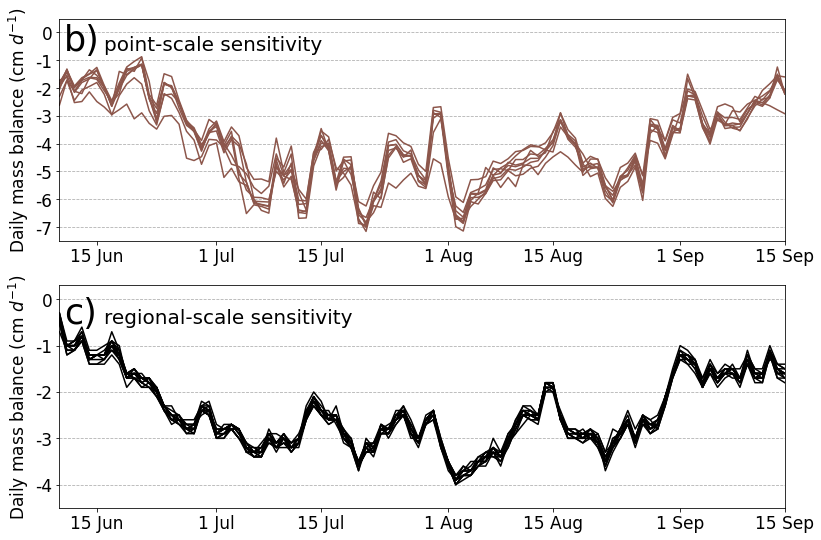

In [60]:
import glob
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

fig, ax = plt.subplots(2, 1, figsize=(13, 9))
#ig.subplots_adjust(hspace=0.03)


t0 = 252
t1 = 349
unc_alg = 0.16

if t1-t0<= 30:
    unc_alg = 0.0081
    unc_alg = (unc_alg*(t1-t0))/((t1-t0)**(1/2))

indexes = [259, 260, 261, 261, 263, 264, 286, 287, 288, 289, 290, 291, 293, 294, 295, 296, 297, 298, 303, 304, 305, 306, 307, 308, 309]
indexes=None
# error of climatology
folder = "C:\\Users\\Aaron\\Documents\\pubblications\\paper1_anomalies\\data\\uncertainty\\rho_p5"
clim_unc = pd.DataFrame()
file_names = []

for filename in os.listdir(folder):
    if 'point' in filename:
        continue
    file_names.append(filename[:-4])
    path = os.path.join(folder,filename)
    clim = import_climatology(path)

    clim = clim.groupby(['DOY']).mean().reset_index()
    clim_unc = pd.concat([clim_unc, clim['balance(b)']/1000], axis=1)
    
clim_unc.columns = file_names
temp_clim_unc = clim_unc[clim_unc.index>274]
temp_clim_unc = pd.concat([temp_clim_unc, clim_unc[clim_unc.index<=274]])
temp_clim_unc = temp_clim_unc.reset_index()


clim_unc = temp_clim_unc

clim_unc = clim_unc - clim_unc.shift(1)
clim_unc = clim_unc.dropna()

# error calculation daily


if indexes is not None:
    clim_unc = clim_unc.iloc[indexes]
else:
    clim_unc = clim_unc[clim_unc.index>=t0]
    clim_unc = clim_unc[clim_unc.index<=t1]
    
#print(clim_unc)

sigma_dt1 = np.abs(clim_unc['cumulative_rho_P5']-clim_unc['cumulative_rho_P5_dT0'])
sigma_dt2 = np.abs(clim_unc['cumulative_rho_P5']-clim_unc['cumulative_rho_P5_dT2'])
sigma_dt = pd.concat([sigma_dt1, sigma_dt2], axis=1).mean(axis=1)**2

sigma_m1 = np.abs(clim_unc['cumulative_rho_P5']-clim_unc['cumulative_rho_P5_m0'])
sigma_m2 = np.abs(clim_unc['cumulative_rho_P5']-clim_unc['cumulative_rho_P5_m2'])
sigma_m = pd.concat([sigma_m1, sigma_m2], axis=1).mean(axis=1)**2

sigma_meteo1 = np.abs(clim_unc['cumulative_rho_P5']-clim_unc['cumulative_rho_P5_Meteo2'])
sigma_meteo2 = np.abs(clim_unc['cumulative_rho_P5']-clim_unc['cumulative_rho_P5_Meteo3'])
sigma_meteo = pd.concat([sigma_meteo1, sigma_meteo2], axis=1).mean(axis=1)**2

sigma_r1 = np.abs(clim_unc['cumulative_rho_P5']-clim_unc['cumulative_rho_P5_r0'])
sigma_r2 = np.abs(clim_unc['cumulative_rho_P5']-clim_unc['cumulative_rho_P5_r2'])
sigma_r = pd.concat([sigma_r1, sigma_r2], axis=1).mean(axis=1)**2

#print(sigma_r)

sigma_tot_dp = sigma_dt + sigma_m + sigma_meteo + sigma_r
sigma_tot_dp = sigma_tot_dp**(1/2)
print('mean uncertainty climatology daily: ', np.min(sigma_tot_dp), np.mean(sigma_tot_dp), np.max(sigma_tot_dp), 'm')

ax[0].plot(clim_unc['cumulative_rho_P5_dT0']*100, label = 'cumulative_rho_P5_dT0', color='tab:brown')
ax[0].plot(clim_unc['cumulative_rho_P5_dT2']*100, label = 'cumulative_rho_P5_dT2', color='tab:brown')
ax[0].plot(clim_unc['cumulative_rho_P5_m0']*100, label = 'cumulative_rho_P5_m0', color='tab:brown')
ax[0].plot(clim_unc['cumulative_rho_P5_m2']*100, label = 'cumulative_rho_P5_m2', color='tab:brown')
ax[0].plot(clim_unc['cumulative_rho_P5_Meteo2']*100, label = 'cumulative_rho_P5_Meteo2', color='tab:brown')
ax[0].plot(clim_unc['cumulative_rho_P5_Meteo3']*100, label = 'cumulative_rho_P5_Meteo3', color='tab:brown')
ax[0].plot(clim_unc['cumulative_rho_P5_r0']*100, label = 'cumulative_rho_P5_r0', color='tab:brown')
ax[0].plot(clim_unc['cumulative_rho_P5_r2']*100, label = 'cumulative_rho_P5_r2', color='tab:brown')
#ax[0].legend()
# error calculation saison

clim_unc = clim_unc.sum(axis=0)

sigma_dt1 = np.abs(clim_unc['cumulative_rho_P5']-clim_unc['cumulative_rho_P5_dT0'])
sigma_dt2 = np.abs(clim_unc['cumulative_rho_P5']-clim_unc['cumulative_rho_P5_dT2'])
sigma_dt = (np.mean([sigma_dt1, sigma_dt2]))**2

sigma_m1 = np.abs(clim_unc['cumulative_rho_P5']-clim_unc['cumulative_rho_P5_m0'])
sigma_m2 = np.abs(clim_unc['cumulative_rho_P5']-clim_unc['cumulative_rho_P5_m2'])
sigma_m = (np.mean([sigma_m1, sigma_m2]))**2

sigma_meteo1 = np.abs(clim_unc['cumulative_rho_P5']-clim_unc['cumulative_rho_P5_Meteo2'])
sigma_meteo2 = np.abs(clim_unc['cumulative_rho_P5']-clim_unc['cumulative_rho_P5_Meteo3'])
sigma_meteo = (np.mean([sigma_meteo1, sigma_meteo2]))**2

sigma_r1 = np.abs(clim_unc['cumulative_rho_P5']-clim_unc['cumulative_rho_P5_r0'])
sigma_r2 = np.abs(clim_unc['cumulative_rho_P5']-clim_unc['cumulative_rho_P5_r2'])
sigma_r = (np.mean([sigma_r1, sigma_r2]))**2

sigma_tot_sp = sigma_dt + sigma_m + sigma_meteo + sigma_r
sigma_tot_sp = sigma_tot_sp**(1/2)
print('uncertainty climatology season: ', np.mean(sigma_tot_sp), 'm')

# error of the swiss wide mb curve
folder = "C:\\Users\\Aaron\\Documents\\pubblications\\paper1_anomalies\\data\\uncertainty\\CH_daily"

glacier_area_ch = 961000000 #m2
do_hyd_y=df_biases.index+(365-274)
df_biases = df_biases.set_index(do_hyd_y)
mean_anomaly = df_biases['mean']
mean_anomaly = pd.concat([pd.DataFrame(np.arange(251)*np.nan),mean_anomaly, pd.DataFrame(np.arange(356,365,1)*np.nan, index=np.arange(356,365,1))])

mb_ch_extreme_unc = pd.DataFrame()
file_names = []

for filename in os.listdir(folder):
    
    if filename=='CH_daily_basin.dat':
        continue
    file_names.append(filename[:-4]) 
    
    path = os.path.join(folder,filename)
    head = pd.read_csv(path, sep=';', skiprows=3, skipinitialspace=True, header=0, nrows=0, encoding='latin1').columns
    usecols = np.arange(len(head))
    mb_ch = pd.read_csv(path, skiprows=4, sep='\s+', skipinitialspace=True, header=None,
                    names=['month', 'day', 'cum_mb', 'mass_change', 'bathtubs_persec'])
    
#    try:
#        mb_ch_extreme = pd.DataFrame(mb_ch.cum_mb + np.cumsum(np.nan_to_num(mean_anomaly[0])))
#    except:
#        mb_ch_extreme = pd.DataFrame(mb_ch.cum_mb + np.cumsum(np.nan_to_num(mean_anomaly[0][:-1])))

    mb_ch_extreme_unc = pd.concat([mb_ch_extreme_unc, mb_ch.cum_mb], axis=1)
    #ax.plot(mb_ch_extreme.cum_mb)

    #mb_ch_extreme_unc = mb_ch.cum_mb
    
mb_ch_extreme_unc.columns = file_names

#seasonal_mb_tot = mb_ch_extreme_unc['CH_daily_ref'][t0]-mb_ch_extreme_unc['CH_daily_ref'][t1]

mb_ch_extreme_unc = mb_ch_extreme_unc - mb_ch_extreme_unc.shift(1)
mb_ch_extreme_unc = mb_ch_extreme_unc.dropna()

# error calculation daily
if indexes is not None:
    mb_ch_extreme_unc = mb_ch_extreme_unc.iloc[indexes]
else:
    mb_ch_extreme_unc = mb_ch_extreme_unc[mb_ch_extreme_unc.index>=t0]
    mb_ch_extreme_unc = mb_ch_extreme_unc[mb_ch_extreme_unc.index<=t1]

seasonal_mb_tot = -mb_ch_extreme_unc['CH_daily_ref'].sum(axis=0)
daily_mb_tot = -mb_ch_extreme_unc['CH_daily_ref']
#print(seasonal_mb_tot)

sigma_area1 = np.abs(mb_ch_extreme_unc['CH_daily_ref']-mb_ch_extreme_unc['CH_daily_area2'])
sigma_area2 = np.abs(mb_ch_extreme_unc['CH_daily_ref']-mb_ch_extreme_unc['CH_daily_area0'])
sigma_area = pd.concat([sigma_area1, sigma_area2], axis=1).mean(axis=1)**2

sigma_dens1 = np.abs(mb_ch_extreme_unc['CH_daily_ref']-mb_ch_extreme_unc['CH_daily_dens2'])
sigma_dens2 = np.abs(mb_ch_extreme_unc['CH_daily_ref']-mb_ch_extreme_unc['CH_daily_dens0'])
sigma_dens = pd.concat([sigma_dens1, sigma_dens2], axis=1).mean(axis=1)**2

sigma_per1 = np.abs(mb_ch_extreme_unc['CH_daily_ref']-mb_ch_extreme_unc['CH_daily_per2'])
sigma_per2 = np.abs(mb_ch_extreme_unc['CH_daily_ref']-mb_ch_extreme_unc['CH_daily_per0'])
sigma_per = pd.concat([sigma_per1, sigma_per2], axis=1).mean(axis=1)**2

sigma_dv1 = np.abs(mb_ch_extreme_unc['CH_daily_ref']-mb_ch_extreme_unc['CH_daily_randomdV1'])
sigma_dv2 = np.abs(mb_ch_extreme_unc['CH_daily_ref']-mb_ch_extreme_unc['CH_daily_randomdV2'])
sigma_dv3 = np.abs(mb_ch_extreme_unc['CH_daily_ref']-mb_ch_extreme_unc['CH_daily_randomdV3'])
sigma_dv = pd.concat([sigma_dv1, sigma_dv2, sigma_dv3], axis=1).mean(axis=1)**2

sigma_set1 = np.abs(mb_ch_extreme_unc['CH_daily_ref']-mb_ch_extreme_unc['CH_daily_set1'])
sigma_set2 = np.abs(mb_ch_extreme_unc['CH_daily_ref']-mb_ch_extreme_unc['CH_daily_set2'])
sigma_set3 = np.abs(mb_ch_extreme_unc['CH_daily_ref']-mb_ch_extreme_unc['CH_daily_set3'])
sigma_set4 = np.abs(mb_ch_extreme_unc['CH_daily_ref']-mb_ch_extreme_unc['CH_daily_set4'])
sigma_set5 = np.abs(mb_ch_extreme_unc['CH_daily_ref']-mb_ch_extreme_unc['CH_daily_set5'])
sigma_set = pd.concat([sigma_set1, sigma_set2, sigma_set3, sigma_set4, sigma_set5], axis=1).mean(axis=1)**2

sigma_tot_dr =  sigma_dv + sigma_set + sigma_dens #sigma_area + sigma_per
sigma_tot_dr = sigma_tot_dr**(1/2)
print('uncertainty regional daily: ', np.min(sigma_tot_dr), np.mean(sigma_tot_dr), np.max(sigma_tot_dr), 'm?')

ax[1].plot(mb_ch_extreme_unc['CH_daily_area2']*100, label = 'CH_daily_area2', color='black')
ax[1].plot(mb_ch_extreme_unc['CH_daily_area0']*100, label = 'CH_daily_area0', color='black')
ax[1].plot(mb_ch_extreme_unc['CH_daily_dens2']*100, label = 'CH_daily_dens2', color='black')
ax[1].plot(mb_ch_extreme_unc['CH_daily_dens0']*100, label = 'CH_daily_dens0', color='black')
ax[1].plot(mb_ch_extreme_unc['CH_daily_per2']*100, label = 'CH_daily_per2', color='black')
ax[1].plot(mb_ch_extreme_unc['CH_daily_per0']*100, label = 'CH_daily_per0', color='black')
ax[1].plot(mb_ch_extreme_unc['CH_daily_randomdV1']*100, label = 'CH_daily_randomdV1', color='black')
ax[1].plot(mb_ch_extreme_unc['CH_daily_randomdV2']*100, label = 'CH_daily_randomdV2', color='black')
ax[1].plot(mb_ch_extreme_unc['CH_daily_randomdV3']*100, label = 'CH_daily_randomdV3', color='black')
ax[1].plot(mb_ch_extreme_unc['CH_daily_randomdV4']*100, label = 'CH_daily_randomdV4', color='black')
ax[1].plot(mb_ch_extreme_unc['CH_daily_randomdV5']*100, label = 'CH_daily_randomdV5', color='black')

ax[1].plot(mb_ch_extreme_unc['CH_daily_set1']*100, label = 'CH_daily_set1', color='black')
ax[1].plot(mb_ch_extreme_unc['CH_daily_set2']*100, label = 'CH_daily_set2', color='black')
ax[1].plot(mb_ch_extreme_unc['CH_daily_set3']*100, label = 'CH_daily_set3', color='black')
ax[1].plot(mb_ch_extreme_unc['CH_daily_set4']*100, label = 'CH_daily_set4', color='black')
ax[1].plot(mb_ch_extreme_unc['CH_daily_set5']*100, label = 'CH_daily_set5', color='black')
ax[0].set_xlim([252, 349])
ax[1].set_xlim([252, 349])


ax[0].set_yticks(np.arange(0,-8,-1), np.arange(0,-8,-1))
ax[1].set_yticks(np.arange(1,-5,-1), np.arange(1,-5,-1))
ax[0].set_ylim([-7.5, 0.5])
ax[1].set_ylim([-4.5, 0.3])

ax[0].grid(True, axis='y', linestyle='--')
ax[1].grid(True, axis='y', linestyle='--')

fig.text(0.13,0.83, 'b)', fontsize=35)
fig.text(0.173,0.83, 'point-scale sensitivity', fontsize=20)

fig.text(0.13 ,0.41, 'c)', fontsize=35)
fig.text(0.173,0.41, 'regional-scale sensitivity', fontsize=20)


ax[0].set_ylabel('Daily mass balance (cm $d^{-1}$)', fontsize = 17)
ax[0].set_xticks([257, 273, 287, 304, 318, 335, 349], ['15 Jun', '1 Jul', '15 Jul', '1 Aug', '15 Aug', '1 Sep', '15 Sep'])
ax[1].set_ylabel('Daily mass balance (cm $d^{-1}$)', fontsize = 17)
ax[1].set_xticks([257, 273, 287, 304, 318, 335, 349], ['15 Jun', '1 Jul', '15 Jul', '1 Aug', '15 Aug', '1 Sep', '15 Sep'])

for a in ax:
    a.tick_params(axis='both', which='both', labelsize=17)
    
plt.savefig('C:\\Users\\Aaron\\Documents\\pubblications\\paper1_anomalies\\writing\\glacier_anomalies\\pictures\\uncertainty_point_region.png')

#plt.legend()

#error calculation saison

mb_ch_extreme_unc = mb_ch_extreme_unc.sum(axis=0)

sigma_area1 = np.abs(mb_ch_extreme_unc['CH_daily_ref']-mb_ch_extreme_unc['CH_daily_area2'])
sigma_area2 = np.abs(mb_ch_extreme_unc['CH_daily_ref']-mb_ch_extreme_unc['CH_daily_area0'])
sigma_area = ((sigma_area1 + sigma_area2)/2)**2

sigma_dens1 = np.abs(mb_ch_extreme_unc['CH_daily_ref']-mb_ch_extreme_unc['CH_daily_dens2'])
sigma_dens2 = np.abs(mb_ch_extreme_unc['CH_daily_ref']-mb_ch_extreme_unc['CH_daily_dens0'])
sigma_dens = ((sigma_dens1 + sigma_dens2)/2)**2

sigma_per1 = np.abs(mb_ch_extreme_unc['CH_daily_ref']-mb_ch_extreme_unc['CH_daily_per2'])
sigma_per2 = np.abs(mb_ch_extreme_unc['CH_daily_ref']-mb_ch_extreme_unc['CH_daily_per0'])
sigma_per = ((sigma_per1 + sigma_per2)/2)**2

sigma_dv1 = np.abs(mb_ch_extreme_unc['CH_daily_ref']-mb_ch_extreme_unc['CH_daily_randomdV1'])
sigma_dv2 = np.abs(mb_ch_extreme_unc['CH_daily_ref']-mb_ch_extreme_unc['CH_daily_randomdV2'])
sigma_dv3 = np.abs(mb_ch_extreme_unc['CH_daily_ref']-mb_ch_extreme_unc['CH_daily_randomdV3'])
sigma_dv = np.mean([sigma_dv1, sigma_dv2, sigma_dv3])**2

sigma_set1 = np.abs(mb_ch_extreme_unc['CH_daily_ref']-mb_ch_extreme_unc['CH_daily_set1'])
sigma_set2 = np.abs(mb_ch_extreme_unc['CH_daily_ref']-mb_ch_extreme_unc['CH_daily_set2'])
sigma_set3 = np.abs(mb_ch_extreme_unc['CH_daily_ref']-mb_ch_extreme_unc['CH_daily_set3'])
sigma_set4 = np.abs(mb_ch_extreme_unc['CH_daily_ref']-mb_ch_extreme_unc['CH_daily_set4'])
sigma_set5 = np.abs(mb_ch_extreme_unc['CH_daily_ref']-mb_ch_extreme_unc['CH_daily_set5'])
sigma_set = np.mean([sigma_set1, sigma_set2, sigma_set3, sigma_set4, sigma_set5])**2

sigma_tot_sr =   sigma_dv + sigma_set + sigma_dens #sigma_area + sigma_per
sigma_tot_sr = sigma_tot_sr**(1/2)
print('uncertainty regional season: ', sigma_tot_sr, 'm?')

total_seasonal_unc_method = (unc_alg**2 + sigma_tot_sr**2 + sigma_tot_sp**2)**(1/2)

total_daily_unc_method = ((0.0081*np.ones(len(sigma_tot_dr)))**2 + sigma_tot_dr**2 + sigma_tot_dp**2)**(1/2)
#print(np.mean(sigma_tot_dr), np.mean(sigma_tot_dp))
total_daily_unc_method = total_daily_unc_method
print('ooo', total_daily_unc_method*100)
#total_seasonal_unc_method = (sigma_tot_sr**2)**(1/2) uncomment for long term runoff unc
#seasonal_mb_tot = mb_ch.cum_mb[252] - mb_ch.cum_mb[349]

unc_area = 22000000

unc_runoff = (seasonal_mb_tot*glacier_area_ch) * ((unc_area/glacier_area_ch)**2 + (total_seasonal_unc_method/seasonal_mb_tot)**2)**(1/2)
unc_runoff_daily = (daily_mb_tot*glacier_area_ch) * ((unc_area/glacier_area_ch)**2 + (total_daily_unc_method/daily_mb_tot)**2)**(1/2)

print(seasonal_mb_tot*glacier_area_ch/1000000000, '+-', unc_runoff/1000000000)
#plt.plot(unc_runoff_daily/1000000000)
unc_runoff_daily.min()/10000000, unc_runoff_daily.mean()/10000000, unc_runoff_daily.max()/10000000

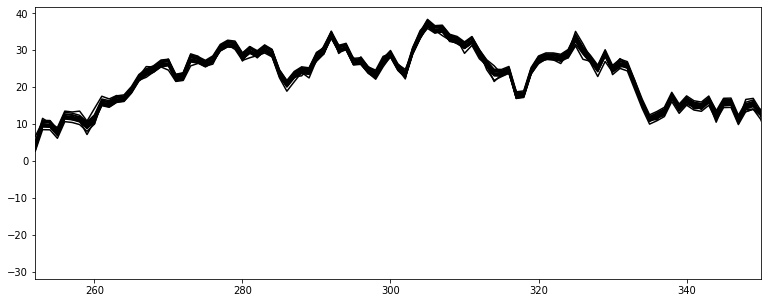

In [43]:
folder = "C:\\Users\\Aaron\\Documents\\pubblications\\paper1_anomalies\\data\\uncertainty\\CH_daily"

fig, ax = plt.subplots(1, 1, figsize=(13, 5))

for filename in os.listdir(folder):
    
    if filename=='CH_daily_basin.dat':
        continue
    file_names.append(filename[:-4]) 
    
    path = os.path.join(folder,filename)
    head = pd.read_csv(path, sep=';', skiprows=3, skipinitialspace=True, header=0, nrows=0, encoding='latin1').columns
    usecols = np.arange(len(head))
    mb_ch = pd.read_csv(path, skiprows=4, sep='\s+', skipinitialspace=True, header=None,
                    names=['month', 'day', 'cum_mb', 'mass_change', 'bathtubs_persec'])
    ax.plot(-mb_ch.mass_change, color='black')
plt.xlim(252,350)
plt.show()

In [ ]:
(0.05**2 + 0.04 *2 + 0.06**2)**(1/2)
(0.0081**2 + 0.0058 *2 + 0.0016**2)**(1/2)

#plt.plot(mb_ch_extreme_unc.mean(axis=1))
#plt.fill_between(np.arange(365), mb_ch_extreme_unc.min(axis=1), mb_ch_extreme_unc.max(axis=1), alpha=0.8)

#mb_ch_extreme_min = mb_ch_extreme_unc.min(axis=1)
#mb_ch_extreme_max = mb_ch_extreme_unc.max(axis=1)

#mb_ch_extreme_min = mb_ch_extreme_min - mb_ch_extreme_min.shift(1)
#mb_ch_extreme_min = mb_ch_extreme_min.dropna()

#mb_ch_extreme_max = mb_ch_extreme_max - mb_ch_extreme_max.shift(1)
#mb_ch_extreme_max = mb_ch_extreme_max.dropna()

#upper bound
#june_hw_max = mb_ch_extreme_max[mb_ch_extreme_max.index>=259]
#june_hw_max = june_hw_max[june_hw_max.index<=264]

#july_hw_max = mb_ch_extreme_max[mb_ch_extreme_max.index>=286]
#july_hw_max = july_hw_max[july_hw_max.index<=298]

#august_hw_max = mb_ch_extreme_max[mb_ch_extreme_max.index>=303]
#august_hw_max = august_hw_max[august_hw_max.index<=309]

#lower bound
#june_hw_min = mb_ch_extreme_min[mb_ch_extreme_min.index>=259]
#june_hw_min = june_hw_min[june_hw_min.index<=264]

#july_hw_min = mb_ch_extreme_min[mb_ch_extreme_min.index>=286]
#july_hw_min = july_hw_min[july_hw_min.index<=298]

#august_hw_min = mb_ch_extreme_min[mb_ch_extreme_min.index>=303]
#august_hw_min = august_hw_min[august_hw_min.index<=309]

#mean
#june_hw = mb_ch_extreme[mb_ch_extreme.index>=259]
#june_hw = june_hw[june_hw.index<=264]

#july_hw = mb_ch_extreme[mb_ch_extreme.index>=286]
#july_hw = july_hw[july_hw.index<=298]

#august_hw = mb_ch_extreme[mb_ch_extreme.index>=303]
#august_hw = august_hw[august_hw.index<=309]

#tot_melt_june_hw_max = np.sum(june_hw_max)
#tot_melt_july_hw_max = np.sum(july_hw_max)
#tot_melt_august_hw_max = np.sum(august_hw_max)

#tot_melt_june_hw_min = np.sum(june_hw_min)
#tot_melt_july_hw_min = np.sum(july_hw_min)
#tot_melt_august_hw_min = np.sum(august_hw_min)

#print((np.cumsum(mb_ch_extreme_max)[252] - np.cumsum(mb_ch_extreme_max)[349])*glacier_area_ch)
#print((np.cumsum(mb_ch_extreme_min)[252] - np.cumsum(mb_ch_extreme_min)[349])*glacier_area_ch)

#print(tot_melt_june_hw_max*glacier_area_ch + tot_melt_july_hw_max*glacier_area_ch+ tot_melt_august_hw_max*glacier_area_ch)
#print(tot_melt_june_hw_min*glacier_area_ch + tot_melt_july_hw_min*glacier_area_ch+ tot_melt_august_hw_min*glacier_area_ch)

# Scatter plot validation
FIN2 FIN1 PLM RHO3 RHO2 RHO1

In [ ]:
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

auto_2019 =   [-4.17, -6.19, -4.02, -3.12, -2.44, -4.14]
manual_2019 = [-4.12, -6.10, -4.09, -2.91, -2.43, -4.13]
insitu_2019 = [-4.06, -5.88, np.nan, -2.96, -2.47, -3.78] # PLM -2.82

auto_2020 =   [-1.57, -5.75, -1.28, -3.31, -6.41, -6.47]
manual_2020 = [-1.47, -5.54, -1.17, -2.87, -6.06, -6.53]
insitu_2020 = [-1.64, -5.74, -1.20, -3.20, -6.14, np.nan] #RHO1 -7.86]

auto_2021 =   [-2.10, -2.90, -3.60, -2.04, -5.83, -5.20]
manual_2021 = [-2.15, -3.05, -3.23, -2.09, -5.61, -5.32]
insitu_2021 = [-2.21, -2.65, -3.24, -2.22, np.nan, -5.28]# RHO2 -4.98

val_19 = pd.DataFrame([auto_2019, manual_2019, insitu_2019], columns= ['FIN2', 'FIN1', 'PLM', 'RHO3', 'RHO2', 'RHO1'], index=['auto', 'manual', 'insitu'])
val_20 = pd.DataFrame([auto_2020, manual_2020, insitu_2020], columns= ['FIN2', 'FIN1', 'PLM', 'RHO3', 'RHO2', 'RHO1'], index=['auto', 'manual', 'insitu'])
val_21 = pd.DataFrame([auto_2021, manual_2021, insitu_2021], columns= ['FIN2', 'FIN1', 'PLM', 'RHO3', 'RHO2', 'RHO1'], index=['auto', 'manual', 'insitu'])

fig, ax = plt.subplots(figsize=(8, 8))

for i in range(6):    
    if i==0: 
        color = 'darkred'
        name= 'FIN2'
    elif i==1:
        color = 'salmon' 
        name='FIN1'
    elif i==2:
        color = 'gold'
        name='PLM'
    elif i==3:
        color = 'lightskyblue'
        name='RHO3'
    elif i==4:
        color = 'royalblue'
        name='RHO2'
    else:
        color = 'darkblue'
        name='RHO1'
            
    ax.scatter(auto_2019[i], manual_2019[i], color=color, marker='^', s=90, edgecolor='black')
    ax.scatter(auto_2020[i], manual_2020[i], color=color, marker='^', s=90, edgecolor='black')
    ax.scatter(auto_2021[i], manual_2021[i], color=color, marker='^', s=90, edgecolor='black')
    
    if not i==2:
        ax.scatter(auto_2019[i], insitu_2019[i], color=color, marker='s', s=90, edgecolor='black')
    
    ax.scatter(auto_2020[i], insitu_2020[i], color=color, marker='s', s=90, edgecolor='black')
    
    if not i==4:
        ax.scatter(auto_2021[i], insitu_2021[i], color=color,marker='s', s=90, edgecolor='black')
    
    
legend_elements = [Line2D([], [], marker='s', color='black', label='In-situ', markerfacecolor='w', markersize=15, linestyle='None'),
                   Line2D([], [], marker='^', color='black', label='Visual', markerfacecolor='w', markersize=15, linestyle='None'),
                   Patch(facecolor='darkred', edgecolor='black', label='FIN2'),
                   Patch(facecolor='salmon', edgecolor='black', label='FIN1'),
                   Patch(facecolor='gold', edgecolor='black', label='PLM'),
                   Patch(facecolor='lightskyblue', edgecolor='black', label='RHO3'),
                   Patch(facecolor='royalblue', edgecolor='black', label='RHO2'),
                   Patch(facecolor='darkblue', edgecolor='black', label='RHO1')
                  ]
    
ax.plot([-8,-1], [-8,-1], color='black')
ax.legend(handles=legend_elements, fontsize=15)
plt.xlim([-7,-1])
plt.ylim([-7,-1])

plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
plt.xlabel('Automatically-retrieved mass balance (m)', fontsize=17)
plt.ylabel('Reference mass balance (m)', fontsize=17)
plt.grid(True, axis='both', linestyle='--')
fig.text(0.53,0.175, 'MAD = 0.16 m', fontsize=25)

plt.savefig('C:\\Users\\Aaron\\Documents\\pubblications\\paper1_anomalies\\writing\\glacier_anomalies\\pictures\\validation_scatterplot.png')

plt.show()


In [ ]:
#RMSE
from sklearn.metrics import mean_squared_error
import math

# concat
manual = np.concatenate((manual_2019, manual_2020, manual_2021))
auto = np.concatenate((auto_2019, auto_2020, auto_2021))
insitu = np.concatenate((insitu_2019, insitu_2020, insitu_2021))

auto_auto = np.concatenate((auto,auto))
manual_insitu = np.concatenate((manual,insitu))

#2 calculate rmse
#math.sqrt(mean_squared_error(auto_auto, manual_insitu)) 
np.nanmean(abs(-auto_auto+ manual_insitu))


# Upscaling

(-1.0136577385260628, 3.8453100471236317)

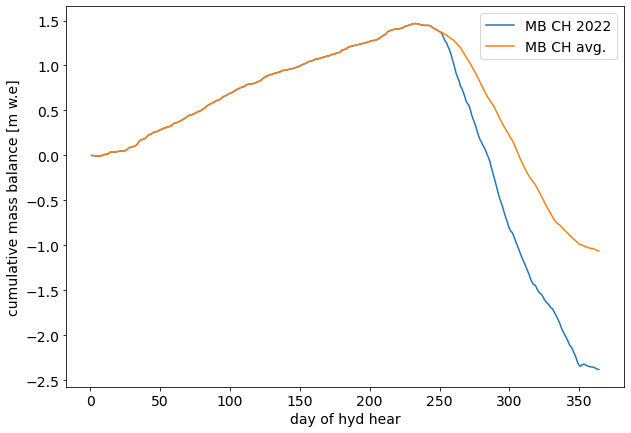

In [10]:
path = "C:\\Users\\Aaron\\Documents\\pubblications\\paper1_anomalies\\data\\Swisswide_mb\\CH_daily.dat"
head = pd.read_csv(
    path, sep=';', skiprows=3, skipinitialspace=True,
    header=0, nrows=0, encoding='latin1').columns
usecols = np.arange(len(head))
mb_ch = pd.read_csv(path, skiprows=4, sep='\s+', skipinitialspace=True, header=None,
                    names=['month', 'day', 'cum_mb', 'mass_change', 'bathtubs_persec'])

#plt.plot(mb_ch.cum_mb)
glacier_area_ch = 961000000 #m2
do_hyd_y=df_biases.index+(365-274)
df_biases = df_biases.set_index(do_hyd_y)
mean_anomaly = df_biases['mean']
mean_anomaly = pd.concat([pd.DataFrame(np.arange(251)*np.nan),mean_anomaly, pd.DataFrame(np.arange(356,365,1)*np.nan, index=np.arange(356,365,1))])
try:
    mb_ch_extreme = pd.DataFrame(mb_ch.cum_mb + np.cumsum(np.nan_to_num(mean_anomaly[0])))
except:
    mb_ch_extreme = pd.DataFrame(mb_ch.cum_mb + np.cumsum(np.nan_to_num(mean_anomaly[0][:-1])))
    
mb_ch_extreme['rate'] = mb_ch_extreme['cum_mb'] - mb_ch_extreme['cum_mb'].shift(1)
mb_ch_extreme = mb_ch_extreme.dropna()

mb_ch['rate'] = mb_ch['cum_mb'] - mb_ch['cum_mb'].shift(1)
mb_ch = mb_ch.dropna()


heat_wave = df_biases['mean'][df_biases['mean']<=-0.0255]
idx_heat_wave_hyd_year = heat_wave.index
extreme_days_melt = mb_ch_extreme.rate[idx_heat_wave_hyd_year]


fig, ax = plt.subplots(figsize=(10, 7))
ax.plot(mb_ch_extreme.cum_mb, label='MB CH 2022')
ax.plot(mb_ch.cum_mb, label='MB CH avg.')
ax.tick_params(axis='both', which='major', labelsize=14)
plt.legend(fontsize=14)
plt.xlabel('day of hyd hear', fontsize=14)
plt.ylabel('cumulative mass balance [m w.e]', fontsize=14)

melt_during_heatwaves = np.sum(mb_ch_extreme.rate[idx_heat_wave_hyd_year])
tot_melt = np.max(mb_ch_extreme.cum_mb) - np.min(mb_ch_extreme.cum_mb)
melt_during_heatwaves, tot_melt

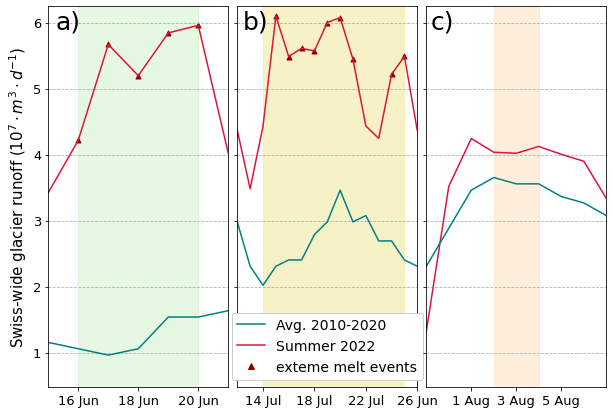

(-304925046.2222472, -684485398.9540542, -278378472.8286961)

In [22]:
from matplotlib.lines import Line2D

#plt.scatter(idx_heat_wave_hyd_year,mb_ch_extreme.rate[idx_heat_wave_hyd_year])
mb_ch_extreme.rate[idx_heat_wave_hyd_year]

fig, axes = plt.subplots(1, 3, figsize=(10, 7), sharey=True)
fig.subplots_adjust(wspace=0.05)

#extreme_days_melt[extreme_days_melt.index<=263]
june_hw = mb_ch_extreme[mb_ch_extreme.index>=259]
june_hw = june_hw[june_hw.index<=264]

june_hw_c = mb_ch[mb_ch.index>=259]
june_hw_c = june_hw_c[june_hw_c.index<=264]

july_hw = mb_ch_extreme[mb_ch_extreme.index>=286]
july_hw = july_hw[july_hw.index<=298]

july_hw_c = mb_ch[mb_ch.index>=286]
july_hw_c = july_hw_c[july_hw_c.index<=298]

august_hw = mb_ch_extreme[mb_ch_extreme.index>=303]
august_hw = august_hw[august_hw.index<=309]


axes[0].plot(-mb_ch_extreme['rate']*glacier_area_ch/10000000, color='crimson')
axes[0].plot(-mb_ch['rate']*glacier_area_ch/10000000, color='teal')
axes[0].fill_between(np.arange(258,263,1), 0.07*glacier_area_ch/10000000, 0, alpha=0.5, color='#cbf2c6')
axes[0].scatter(extreme_days_melt.index, -extreme_days_melt*glacier_area_ch/10000000, color='darkred', marker='^', s=25)
axes[0].set_xticks([258, 260, 262], ['16 Jun', '18 Jun', '20 Jun'])
axes[0].set_xlim(257,263)
axes[0].set_ylim(0.005*glacier_area_ch/10000000, 0.065*glacier_area_ch/10000000)

axes[1].plot(-mb_ch_extreme['rate']*glacier_area_ch/10000000, color='crimson')
axes[1].fill_between(np.arange(286,298,1), 0.07*glacier_area_ch/10000000, 0, alpha=0.5, color='khaki')
axes[1].scatter(extreme_days_melt.index, -extreme_days_melt*glacier_area_ch/10000000, color='darkred', marker='^', s=25)
axes[1].plot(-mb_ch['rate']*glacier_area_ch/10000000, color='teal')
axes[1].set_xticks([286, 290, 294, 298], ['14 Jul', '18 Jul', '22 Jul', '26 Jun'])
axes[1].set_xlim(284,298)
axes[1].set_ylim(0.005*glacier_area_ch/10000000, 0.065*glacier_area_ch/10000000)

axes[2].plot(-mb_ch_extreme['rate']*glacier_area_ch/10000000, color='crimson')
axes[2].scatter(extreme_days_melt.index, -extreme_days_melt*glacier_area_ch/10000000, color='darkred', marker='^', s=25)
axes[2].fill_between(np.arange(305, 308,1), 0.07*glacier_area_ch/10000000, 0, alpha=0.6, color='bisque')
axes[2].set_xticks([304, 306, 308], ['1 Aug', '3 Aug', '5 Aug'])
axes[2].plot(-mb_ch['rate']*glacier_area_ch/10000000, color='teal')
axes[2].set_xlim(302,310)
axes[2].set_ylim(0.005*glacier_area_ch/10000000, 0.065*glacier_area_ch/10000000)

axes[0].grid(True, axis='y', linestyle='--')
axes[1].grid(True, axis='y', linestyle='--')
axes[2].grid(True, axis='y', linestyle='--')

fig.text(0.135,0.835, 'a)', fontsize=25)
fig.text(0.395,0.835, 'b)', fontsize=25)
fig.text(0.656,0.835, 'c)', fontsize=25)



legend_elements = [Line2D([], [], marker='None', color='teal', label='Avg. 2010-2020'),
                   Line2D([], [], marker='None', color='crimson', label='Summer 2022'),
                   Line2D([], [], marker='^', color='darkred', label='exteme melt events', linestyle='None')]

axes[1].legend(handles=legend_elements, fontsize=14, loc='lower center', framealpha=1., fancybox=True)
axes[0].set_ylabel('Swiss-wide glacier runoff ($10^7 \cdot m^3 \cdot d^{-1}$)',fontsize=15)

for ax in axes:
    ax.tick_params(axis='both', which='major', labelsize=13)
#plt.savefig('C:\\Users\\Aaron\\Documents\\pubblications\\paper1_anomalies\\writing\\glacier_anomalies\\pictures\\heat_waves_comparison.png')
plt.show()

#plt.plot(extreme_days_melt)
tot_melt_june_hw = np.sum(june_hw.rate)
tot_melt_june_hw_c = np.sum(june_hw_c.rate)

tot_melt_july_hw = np.sum(july_hw.rate)
tot_melt_july_hw_c = np.sum(july_hw_c.rate)

tot_melt_august_hw = np.sum(august_hw.rate)

tot_melt_june_hw*glacier_area_ch, tot_melt_july_hw*glacier_area_ch, tot_melt_august_hw*glacier_area_ch
#(tot_melt_june_hw*glacier_area_ch)/(tot_melt_june_hw_c*glacier_area_ch)
#(tot_melt_july_hw*glacier_area_ch)/(tot_melt_july_hw_c*glacier_area_ch)

In [ ]:
mb_ch_extreme.rate[meteorological_hw]

In [ ]:
runoff_2020 = -mb_ch_extreme.rate[251:]*glacier_area_ch

In [ ]:
runoff_2021 = -mb_ch_extreme.rate[251:]*glacier_area_ch

In [12]:
runoff_2022 = -mb_ch_extreme.rate[251:]*glacier_area_ch

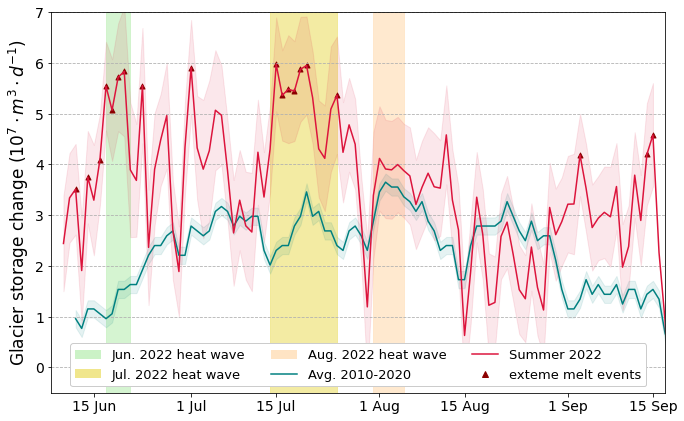

In [13]:
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

fig, ax = plt.subplots(figsize=(11, 7))

mb_ch['rate'] = mb_ch['cum_mb'] - mb_ch['cum_mb'].shift(1)
mb_ch = mb_ch.dropna()

plt.fill_between(np.arange(259,264,1), -2, 7, alpha=0.8, color='#cbf2c6')
plt.fill_between(np.arange(286,298,1), -2, 7, alpha=0.8, color='khaki')
plt.fill_between(np.arange(303,309,1), -2, 7, alpha=0.8, color='bisque')

ax.plot(-mb_ch.rate[251:]*glacier_area_ch/10000000, label='avg 2010-2020', color='teal', linewidth=1.5)
ax.fill_between(mb_ch.rate[251:].index, -mb_ch.rate[251:]*glacier_area_ch/10000000 - 0.17, -mb_ch.rate[251:]*glacier_area_ch/10000000 + 0.17, color='teal', alpha=0.1)

#ax.plot(runoff_2019, label='2019', color='grey')
#ax.plot(runoff_2020, label='2020',color='grey')
#ax.plot(runoff_2021, label='2021', color='grey')
ax.plot(runoff_2022/10000000, label='2022', color='crimson', linewidth=1.5)
ax.fill_between(np.arange(252,365,1), runoff_2022/10000000 - unc_runoff_daily/10000000, runoff_2022/10000000 + unc_runoff_daily/10000000, color='crimson', alpha=0.1)
ax.tick_params(axis='both', which='major', labelsize=14)



ax.scatter(extreme_days_melt.index, -extreme_days_melt.values*glacier_area_ch/10000000, color='darkred', marker='^', s=25)
#ax.scatter(meteorological_hw, np.ones(len(meteorological_hw))*6.2)

plt.ylabel('Glacier storage change ($10^7 \cdot m^3 \cdot d^{-1}$)', fontsize=17)
#plt.xticks([260, 280, 300, 320, 340, 360], ['19 Jun', '8 Jul', '28 Jul', '17 Aug', '6 Sep', '26 Sep'])
plt.xticks([257, 273, 287, 304, 318, 335, 349, 365], ['15 Jun', '1 Jul', '15 Jul', '1 Aug', '15 Aug', '1 Sep', '15 Sep', '1 Oct'])
plt.ylim(-0.5, 7)      
plt.xlim(250, 351)           

legend_elements = [Patch(facecolor='#cbf2c6', label='Jun. 2022 heat wave'),
                   Patch(facecolor='khaki', label='Jul. 2022 heat wave'),
                   Patch(facecolor='bisque', label='Aug. 2022 heat wave'),
                   Line2D([], [], marker='None', color='teal', label='Avg. 2010-2020'),
                   Line2D([], [], marker='None', color='crimson', label='Summer 2022'),
                   Line2D([], [], marker='^', color='darkred', label='exteme melt events', linestyle='None')]

plt.legend(handles=legend_elements, fontsize=13, ncol=3, framealpha=1., loc='lower center')

plt.grid(True, axis='y', linestyle='--')
#plt.savefig('C:\\Users\\Aaron\\Documents\\pubblications\\paper1_anomalies\\writing\\glacier_anomalies\\pictures\\swiss_wide_runoff_unc.png')
plt.show()
#temp = mb_ch_extreme.rate[251:]*glacier_area_ch
#weekly_water = []
#for i in range(20):
#    weekly_water.append(np.sum(temp[0:5]))
#    temp = temp[5:]

In [ ]:
runoff_perc_hw_22 = -(tot_melt_june_hw + tot_melt_july_hw + tot_melt_august_hw)*glacier_area_ch/((mb_ch_extreme.cum_mb[252]-mb_ch_extreme.cum_mb[349])*glacier_area_ch)
runoff_perc_extreme_22 = sum(-extreme_days_melt.values*glacier_area_ch)/((mb_ch_extreme.cum_mb[252]-mb_ch_extreme.cum_mb[349])*glacier_area_ch)
runoff_perc_hw_longterm = -(tot_melt_june_hw + tot_melt_july_hw + tot_melt_august_hw)*glacier_area_ch/((mb_ch.cum_mb[252]-mb_ch.cum_mb[349])*glacier_area_ch)
runoff_perc_extreme_longterm = sum(-extreme_days_melt.values*glacier_area_ch)/((mb_ch.cum_mb[252]-mb_ch.cum_mb[349])*glacier_area_ch)
runoff_perc_hw_22, runoff_perc_extreme_22, runoff_perc_hw_longterm, runoff_perc_extreme_longterm

In [38]:
(-mb_ch_extreme.rate[259:264].mean()*glacier_area_ch/10000000)/(-mb_ch.rate[259:264].mean()*glacier_area_ch/10000000), \
(-mb_ch_extreme.rate[286:298].mean()*glacier_area_ch/10000000)/(-mb_ch.rate[286:298].mean()*glacier_area_ch/10000000), \
-mb_ch.rate[303:309].mean()*glacier_area_ch/10000000, \
-mb_ch_extreme.rate[259:264].mean()*glacier_area_ch/10000000, \
-mb_ch_extreme.rate[286:298].mean()*glacier_area_ch/10000000, \
-mb_ch_extreme.rate[303:309].mean()*glacier_area_ch/10000000


(3.0037345772063864,
 1.947931619109348,
 3.41155,
 4.964932957355972,
 5.335092514997638,
 4.0534865166004215)

In [ ]:
sum(-mb_ch_extreme.rate[meteorological_hw]*glacier_area_ch)/((np.max(mb_ch.cum_mb) - np.min(mb_ch.cum_mb))*glacier_area_ch)

In [ ]:
(np.max(mb_ch.cum_mb) - np.min(mb_ch.cum_mb))*glacier_area_ch

In [63]:
runoff_2022.to_csv('C:\\Users\\Aaron\\Documents\\pubblications\\Heat_wave_contribution_to_2022’s_extreme_glacier_melt\\storage_change2022.csv')

# Find meteorological heat-waves

In [ ]:
path = "C:\\Users\\Aaron\\Documents\\pubblications\\paper1_anomalies\\data\\temp_montana_sion\\order_105887_data.txt"
temp_mon_sio = pd.read_csv(path, skiprows=3, sep=';', names=['station', 'time', 't_hour_max', 't_hour_min', 't_hour_mean'],
                          dtype={'station': str, 'time': str, 't_hour_max': float, 't_hour_min': float, 't_hour_mean': float})

time_dtime = []

for t in temp_mon_sio.time.values:
    try:
        year = int(t[:4])
        month= int(t[4:6])
        day = int(t[6:8])
        hour = int(t[8:])
    except:
        print(t)
    time_dtime.append(dt.datetime(year=year,month=month,day=day, hour=hour))

temp_mon_sio = temp_mon_sio.assign(time=time_dtime)

temp_mon = temp_mon_sio[temp_mon_sio['station']=='MVE']
temp_sio = temp_mon_sio[temp_mon_sio['station']=='SIO']


temp_sio_max = temp_sio[['time', 'station', 't_hour_max']]
temp_sio_min = temp_sio[['time', 'station', 't_hour_min']]
temp_sio_mean = temp_sio[['time', 'station', 't_hour_mean']]



daily_max = temp_sio_max.groupby(pd.Grouper(key='time', freq='1d')).max().reset_index()
daily_min = temp_sio_min.groupby(pd.Grouper(key='time', freq='1d')).min().reset_index()

daily_mean = temp_sio_mean.groupby(pd.Grouper(key='time', freq='1d')).mean().reset_index()

meteorological_hw = daily_mean[daily_mean.t_hour_mean>= 25].index

fig, ax = plt.subplots(figsize=(10, 7))

ax.scatter(daily_max[daily_max.t_hour_max>= 30].time, daily_max[daily_max.t_hour_max>= 30].t_hour_max)
ax.scatter(daily_min[daily_min.t_hour_min>= 20].time, daily_min[daily_min.t_hour_min>= 20].t_hour_min)
ax.scatter(daily_mean[daily_mean.t_hour_mean>= 25].time, daily_mean[daily_mean.t_hour_mean>= 25].t_hour_mean)
meteorological_hw

In [ ]:
# version 2 with 4 stations
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt

path = "C:\\Users\\Aaron\\Documents\\pubblications\\paper1_anomalies\\data\\tmp.txt"
temp_all = pd.read_csv(path, skiprows=1, sep='\s+', names=['station', 'year', 'month', 'day', 'hour', 'minute', 'daily_mean_t', 'daily_max_t', 'night_max_t', 'night_min_t'])#,
                          #dtype={'station': str, 'time': str, 't_hour_max': float, 't_hour_min': float, 't_hour_mean': float})

t_lug = temp_all[temp_all['station']==47]
t_lug = t_lug[t_lug['daily_mean_t']<=50]

t_chu = temp_all[temp_all['station']==27]
t_chu = t_chu[t_chu['daily_mean_t']<=50]

t_zhu = temp_all[temp_all['station']==59]
t_zhu = t_zhu[t_zhu['daily_mean_t']<=50]

t_sio = temp_all[temp_all['station']==49]
t_sio = t_sio[t_sio['daily_mean_t']<=50]

time_dtime = []

for t in t_lug.iterrows():
    try:
        year = int(t[1].year)
        month= int(t[1].month)
        day = int(t[1].day)
    except:
        print(t[1])
        
    time_dtime.append(dt.datetime(year=year,month=month,day=day))

#calculate heat wave when mean t>=25 deg   
t_lug = t_lug.assign(time=time_dtime).reset_index()
t_lug_mean_d = t_lug[['time', 'daily_mean_t']]#, 'daily_max_t', 'night_max_t', 'night_min_t']]

t_chu = t_chu.assign(time=time_dtime).reset_index()
t_chu_mean_d = t_chu[['daily_mean_t']]#, 'daily_max_t', 'night_max_t', 'night_min_t']]

t_zhu = t_lug.assign(time=time_dtime).reset_index()
t_zhu_mean_d = t_lug[['daily_mean_t']]#, 'daily_max_t', 'night_max_t', 'night_min_t']]

t_sio = t_lug.assign(time=time_dtime).reset_index()
t_sio_mean_d = t_lug[['daily_mean_t']]#, 'daily_max_t', 'night_max_t', 'night_min_t']]

t_mean_all = pd.concat([t_lug_mean_d, t_chu_mean_d, t_zhu_mean_d, t_sio_mean_d], axis=1)
t_mean_all = t_mean_all.set_index('time')
meteorological_hw1 = t_mean_all[t_mean_all.mean(axis=1)>=25].index

#calculate heat wave when max t>=30 deg   
t_lug_max_d = t_lug[['time', 'daily_max_t']]#, 'daily_max_t', 'night_max_t', 'night_min_t']]
t_chu_max_d = t_chu[['daily_max_t']]#, 'daily_max_t', 'night_max_t', 'night_min_t']]
t_zhu_max_d = t_lug[['daily_max_t']]#, 'daily_max_t', 'night_max_t', 'night_min_t']]
t_sio_max_d = t_lug[['daily_max_t']]#, 'daily_max_t', 'night_max_t', 'night_min_t']]

t_max_d_all = pd.concat([t_lug_max_d, t_chu_max_d, t_zhu_max_d, t_sio_max_d], axis=1)
t_max_d_all = t_max_d_all.set_index('time')
meteorological_hw2 = t_max_d_all[t_max_d_all.mean(axis=1)>=30].index

#calculate heat wave when max t>=30 deg   
t_lug_min_n = t_lug[['time', 'night_min_t']]#, 'daily_max_t', 'night_max_t', 'night_min_t']]
t_chu_min_n = t_chu[['night_min_t']]#, 'daily_max_t', 'night_max_t', 'night_min_t']]
t_zhu_min_n = t_lug[['night_min_t']]#, 'daily_max_t', 'night_max_t', 'night_min_t']]
t_sio_min_n = t_lug[['night_min_t']]#, 'daily_max_t', 'night_max_t', 'night_min_t']]

t_min_n_all = pd.concat([t_lug_min_n, t_chu_min_n, t_zhu_min_n, t_sio_min_n], axis=1)
t_min_n_all = t_min_n_all.set_index('time')
meteorological_hw3 = t_min_n_all[t_min_n_all.mean(axis=1)>=20].index

meteorological_hw2

In [ ]:
temp_mon = temp_mon_sio[temp_mon_sio['station']=='MVE']
temp_sio = temp_mon_sio[temp_mon_sio['station']=='SIO']


temp_sio_max = temp_sio[['time', 'station', 't_hour_max']]
temp_sio_min = temp_sio[['time', 'station', 't_hour_min']]
temp_sio_mean = temp_sio[['time', 'station', 't_hour_mean']]



daily_max = temp_sio_max.groupby(pd.Grouper(key='time', freq='1d')).max().reset_index()
daily_min = temp_sio_min.groupby(pd.Grouper(key='time', freq='1d')).min().reset_index()
daily_mean = temp_sio_mean.groupby(pd.Grouper(key='time', freq='1d')).mean().reset_index()

meteorological_hw = daily_mean[daily_mean.t_hour_mean>= 25].index

fig, ax = plt.subplots(figsize=(15, 2))

ax.plot(daily_mean.t_hour_mean)
plt.xlim(252, 350)
plt.ylim(16, 29)
plt.xticks([257, 273, 287, 304, 318, 335, 349], ['15 Jun', '1 Jul', '15 Jul', '1 Aug', '15 Aug', '1 Sep', '15 Sep'])

plt.grid(True)
plt.savefig('C:\\Users\\Aaron\\Documents\\pubblications\\paper1_anomalies\\writing\\glacier_anomalies\\pictures\\t_sio_2022.png')
plt.show()
#fig, ax = plt.subplots(figsize=(10, 7))

#ax.scatter(daily_max[daily_max.t_hour_max>= 30].time, daily_max[daily_max.t_hour_max>= 30].t_hour_max)
#ax.scatter(daily_min[daily_min.t_hour_min>= 20].time, daily_min[daily_min.t_hour_min>= 20].t_hour_min)
#ax.scatter(daily_mean[daily_mean.t_hour_mean>= 25].time, daily_mean[daily_mean.t_hour_mean>= 25].t_hour_mean)

#plt.show()
daily_mean

In [ ]:
#plt.plot(temp_sio[temp_sio.time >= dt.datetime(2022, 8, 31)].t_hour_mean.values)
a = temp_sio[temp_sio.time >= dt.datetime(2022, 8, 31)].t_hour_mean.values
print(a)
#plt.plot(a)
plt.plot([1,2,3,2,1])
#temp_mon[temp_mon.time >= dt.datetime(2022, 8, 25)]
#plt.ylim(10, 10)

In [ ]:
temp_mon

In [ ]:
temp_mon_sio = pd.read_csv(path, sep=';', skiprows=0, skipinitialspace=True, header=None, names=['station', 'time', 't_hour_max', 't_hour_min', 't_hour_mean'], dtype={'station': str, 'time': str, 't_hour_max': float, 't_hour_min': float, 't_hour_mean': float})
temp_mon_sio

In [ ]:
type(mb_ch_extreme)